In [1]:
from torch import tensor
import os
from tqdm import tqdm
import torch
import h5py
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

## Enter Dataset, transition matrix, and features

In [2]:
folder = '/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/experiments'
dataset = 'pneuma'  # pneuma, tdrive, geolife, munich
model = 'residual'  # residual, GAT, MLP
transition_matrix = 'marginal_prior'    # custom, marginal_prior
noising = 'cosine'  # cosine, linear
test = True
features = 'one_hot_edges_coordinates_pos_encoding_pw_distance_edge_length_edge_angles_num_pred_edges_future_len_start_end'
history = 2
future = 0
conditional = True
conditional_fut_len = None # None, 10, 15, or 20

# Single sample
Metrics

# Multiplte sample
Metrics

## Load Data

In [3]:
if conditional:
    prefix = 'cond_'
    if test:
        prefix = 'test_' + prefix
elif test:
    prefix = 'test_'
else:
    prefix = ''
if conditional:
    sample_list = torch.load(f'{folder}/{dataset}_{model}/{transition_matrix}_{noising}/{prefix}fut_len_{conditional_fut_len}_samples_one_shot_{features}_hist{history}_fut_{future}.pth')
    valid_ids = torch.load(f'{folder}/{dataset}_{model}/{transition_matrix}_{noising}/{prefix}fut_len_{conditional_fut_len}_valid_ids_{features}_hist{history}_fut_{future}.pth')
    samples_raw = torch.load(f'{folder}/{dataset}_{model}/{transition_matrix}_{noising}/{prefix}fut_len_{conditional_fut_len}_samples_raw_{features}_hist{history}_fut_{future}.pth')
    samples_valid = torch.load(f'{folder}/{dataset}_{model}/{transition_matrix}_{noising}/{prefix}fut_len_{conditional_fut_len}_samples_valid_{features}_hist{history}_fut_{future}.pth')
    ground_truth_hist = torch.load(f'{folder}/{dataset}_{model}/{transition_matrix}_{noising}/{prefix}fut_len_{conditional_fut_len}_gt_hist_{features}_hist{history}_fut_{future}.pth')
    ground_truth_fut = torch.load(f'{folder}/{dataset}_{model}/{transition_matrix}_{noising}/{prefix}fut_len_{conditional_fut_len}_gt_fut_{features}_hist{history}_fut_{future}.pth')
else:
    sample_list = torch.load(f'{folder}/{dataset}_{model}/{transition_matrix}_{noising}/{prefix}samples_one_shot_{features}_hist{history}_fut_{future}.pth')
    valid_ids = torch.load(f'{folder}/{dataset}_{model}/{transition_matrix}_{noising}/{prefix}valid_ids_{features}_hist{history}_fut_{future}.pth')
    samples_raw = torch.load(f'{folder}/{dataset}_{model}/{transition_matrix}_{noising}/{prefix}samples_raw_{features}_hist{history}_fut_{future}.pth')
    samples_valid = torch.load(f'{folder}/{dataset}_{model}/{transition_matrix}_{noising}/{prefix}samples_valid_{features}_hist{history}_fut_{future}.pth')
    ground_truth_hist = torch.load(f'{folder}/{dataset}_{model}/{transition_matrix}_{noising}/{prefix}gt_hist_{features}_hist{history}_fut_{future}.pth')
    ground_truth_fut = torch.load(f'{folder}/{dataset}_{model}/{transition_matrix}_{noising}/{prefix}gt_fut_{features}_hist{history}_fut_{future}.pth')

/tmp/ipykernel_1109610/180933650.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sample_list = torch.load(f'{folder}/{dataset}_{model}/{transition_matrix}_{noising}/{pr

/tmp/ipykernel_1109610/180933650.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  valid_ids = torch.load(f'{folder}/{dataset}_{model}/{transition_matrix}_{noising}/{pref

In [4]:
res = {'sample_list': sample_list, 'samples_valid': samples_valid, 'valid_ids': valid_ids, 'samples_raw': samples_raw, 'ground_truth_hist': ground_truth_hist, 'ground_truth_fut': ground_truth_fut}

## Load Graph

In [5]:
# TODO: Replace with import from trajectory dataset
def load_new_format(file_path, edge_features, device):
        paths = []
        with h5py.File(file_path, 'r') as new_hf:
            node_coordinates = torch.tensor(new_hf['graph']['node_coordinates'][:], dtype=torch.float, device=device)
            # Normalize the coordinates to (0, 1) if any of the coordinates is larger than 1
            if node_coordinates.max() > 1:
                max_values = node_coordinates.max(0)[0]
                min_values = node_coordinates.min(0)[0]
                node_coordinates[:, 0] = (node_coordinates[:, 0] - min_values[0]) / (max_values[0] - min_values[0])
                node_coordinates[:, 1] = (node_coordinates[:, 1] - min_values[1]) / (max_values[1] - min_values[1])
            edges = new_hf['graph']['edges'][:]
            edge_coordinates = node_coordinates[edges]
            nodes = [(i, {'pos': torch.tensor(pos, device=device)}) for i, pos in enumerate(node_coordinates)]
            edges = [tuple(edge) for edge in edges]

            for i in tqdm(new_hf['trajectories'].keys()):
                path_group = new_hf['trajectories'][i]
                path = {attr: torch.tensor(path_group[attr][()], device=device) for attr in path_group.keys() if attr in ['coordinates', 'edge_idxs', 'edge_orientations']}
                paths.append(path)
            if 'road_type' in edge_features:
                onehot_encoded_road_type = new_hf['graph']['road_type'][:]
                return paths, nodes, edges, edge_coordinates, onehot_encoded_road_type
            else:
                return paths, nodes, edges, edge_coordinates
        return paths, nodes, edges, edge_coordinates

if test:
    paths, nodes, edges, edge_coordinates = load_new_format(f'/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/data/{dataset}_test.h5', features, 'cpu')
else:
    paths, nodes, edges, edge_coordinates = load_new_format(f'/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/data/{dataset}_val.h5', features, 'cpu')
indexed_edges = [((start, end), index) for index, (start, end) in enumerate(edges)]
G = nx.Graph()
G.add_nodes_from(nodes)
for (start, end), index in indexed_edges:
        G.add_edge(start, end, index=index, default_orientation=(start, end))

/tmp/ipykernel_1109610/2379480112.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nodes = [(i, {'pos': torch.tensor(pos, device=device)}) for i, pos in enumerate(node_coordinates)]
100%|██████████| 7583/7583 [00:03<00:00, 2320.60it/s]


## Plot Single Sample

In [ ]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_paths_random(ground_truth_hist, ground_truth_fut, samples, edge_coordinates,
                      num_paths_to_plot=4, num_rows=2, num_cols=2, zoom_in=True,
                      valid=False, valid_ids=None, save_path='trajectory_grid.png'):
    """
    Plots a grid of random trajectories with grid lines between subplots.

    Parameters:
    - ground_truth_hist: List of ground truth history edge indices.
    - ground_truth_fut: List of ground truth future edge indices.
    - samples: List of predicted future edge indices.
    - edge_coordinates: Tensor of edge coordinates.
    - num_paths_to_plot: Total number of trajectories to plot.
    - num_rows: Number of rows in the grid.
    - num_cols: Number of columns in the grid.
    - zoom_in: If True, zooms into the trajectory area.
    - valid: If True, uses valid_ids to filter trajectories.
    - valid_ids: List of valid trajectory indices.
    - save_path: File path to save the figure.
    """

    # Set the plotting style and parameters
    plt.style.use('seaborn-v0_8-paper')
    plt.rcParams.update({
        'axes.labelsize': 14,
        'axes.titlesize': 16,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 16,
        'axes.grid': False,
        'grid.alpha': 0.4,
        'lines.linewidth': 2,
    })

    # Calculate the number of subplots needed
    total_plots = num_rows * num_cols
    if num_paths_to_plot > total_plots:
        print(f"Warning: num_paths_to_plot ({num_paths_to_plot}) exceeds grid capacity ({total_plots}).")
        num_paths_to_plot = total_plots

    # Setup the subplot layout
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))
    axs = np.array(axs)  # Ensure axs is a NumPy array

    # Adjust layout to make room for the legend
    plt.subplots_adjust(top=0.95, bottom=0.05, wspace=0.1, hspace=0.1)

    path_count = 0
    attempts = 0  # To prevent infinite loops
    max_attempts = 1000

    while path_count < num_paths_to_plot and attempts < max_attempts:
        batch_idx = torch.randint(0, len(ground_truth_hist), (1,)).item()
        idx = torch.randint(0, len(ground_truth_hist[batch_idx]), (1,)).item()
        attempts += 1

        if valid:
            if valid_ids[batch_idx][idx] is None:
                continue

        if idx >= len(ground_truth_hist[batch_idx]):
            continue

        row = path_count // num_cols
        col = path_count % num_cols
        if num_rows == 1:
            ax = axs[col]
        else:
            ax = axs[row, col]
        ax.cla()

        # Plot all edges as background with lighter color
        for edge in edge_coordinates:
            ax.plot(edge[:, 0], edge[:, 1], color='lightgrey', linewidth=0.5, zorder=1)

        # Define the plot_trajectory function within this function to ensure it uses 'ax'
        def plot_trajectory(edge_indices, color, label, linestyle='-', lw=2):
            edge_indices = edge_indices[edge_indices >= 0]
            added_label = False  # Flag to add label only once
            if edge_indices.dim() == 2:
                edge_indices = edge_indices.squeeze(0)
            if edge_indices.numel() > 0:
                for edge_idx in edge_indices:
                    edge = edge_coordinates[edge_idx]
                    if not added_label and path_count == 0:
                        ax.plot(edge[:, 0], edge[:, 1], color=color, linewidth=lw, linestyle=linestyle,
                                label=label, zorder=2)
                        added_label = True
                    else:
                        ax.plot(edge[:, 0], edge[:, 1], color=color, linewidth=lw, linestyle=linestyle,
                                zorder=2)

        # Plot trajectories with improved styles
        plot_trajectory(ground_truth_hist[batch_idx][idx], color='blue', label='History', linestyle='-', lw=2)
        plot_trajectory(ground_truth_fut[batch_idx][idx], color='green', label='Ground Truth Future', linestyle='-', lw=2)
        plot_trajectory(samples[batch_idx][idx], color='orange', label='Predicted Future', linestyle=':', lw=3)
        
        print(ground_truth_hist[batch_idx][idx])

        if zoom_in:
            # Collect all coordinates from the trajectories
            all_edges = torch.cat(
                [ground_truth_hist[batch_idx][idx], ground_truth_fut[batch_idx][idx], samples[batch_idx][idx]])
            all_edges = all_edges[all_edges >= 0]
            if all_edges.numel() > 0:
                all_coords = edge_coordinates[all_edges].view(-1, 2)
                xmin, xmax = all_coords[:, 0].min(), all_coords[:, 0].max()
                ymin, ymax = all_coords[:, 1].min(), all_coords[:, 1].max()
                x_margin = (xmax - xmin) * 0.2
                y_margin = (ymax - ymin) * 0.2
                ax.set_xlim(xmin - x_margin, xmax + x_margin)
                ax.set_ylim(ymin - y_margin, ymax + y_margin)
        else:
            ax.set_xlim(edge_coordinates[:, :, 0].min(), edge_coordinates[:, :, 0].max())
            ax.set_ylim(edge_coordinates[:, :, 1].min(), edge_coordinates[:, :, 1].max())

        # Remove axes ticks and labels
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')

        path_count += 1  # Increment the path counter

    # Remove any unused subplots
    for i in range(path_count, num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        fig.delaxes(axs[row, col])

    # Adjust the figure canvas to update positions
    fig.canvas.draw()

    # Create an extra axes that covers the entire figure
    ax_grid = fig.add_axes([0, 0, 1, 1], frameon=False)
    ax_grid.set_xticks([])
    ax_grid.set_yticks([])
    ax_grid.set_xlim(0, 1)
    ax_grid.set_ylim(0, 1)

    # Collect positions for vertical lines (columns)
    x_positions = []
    for col in range(1, num_cols):
        if num_rows == 1:
            pos = axs[col - 1].get_position()
        else:
            pos = axs[0, col - 1].get_position()
        x_sep = pos.x1
        x_positions.append(x_sep)

    # Collect positions for horizontal lines (rows)
    y_positions = []
    for row in range(1, num_rows):
        pos = axs[row - 1, 0].get_position()
        y_sep = pos.y0
        y_positions.append(y_sep)

    # Draw vertical grid lines
    for x in x_positions:
        ax_grid.axvline(x=x+0.01, color='lightgrey', linewidth=1)

    # Draw horizontal grid lines
    for y in y_positions:
        ax_grid.axhline(y=y-0.01, color='lightgrey', linewidth=1)

    # Adjust layout and add a single legend
    if num_rows == 1:
        handles, labels = axs[0].get_legend_handles_labels()
    else:
        handles, labels = axs[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.02),
               frameon=True, fontsize=20)

    # Save and show the figure
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


In [ ]:
save_path = f'{folder}/{dataset}_{model}/{transition_matrix}_{noising}/output'
if not os.path.exists(save_path):
    os.makedirs(save_path)
if conditional:
    save_path = save_path + f'/cond_fut_len_{conditional_fut_len}_{features}_hist{history}_fut_{future}.png'
else:
    save_path = save_path + f'/{features}_hist{history}_fut_{future}.png'
print("Saved at", save_path)
plot_paths_random(res['ground_truth_hist'], res['ground_truth_fut'], res['sample_list'], edge_coordinates, num_paths_to_plot=8, num_cols=4, num_rows=2, save_path=save_path, zoom_in=True)

## Plot Valid Samples

In [ ]:
save_path = f'{folder}/{dataset}_{model}/{transition_matrix}_{noising}/output'
if not os.path.exists(save_path):
    os.makedirs(save_path)
save_path = save_path + f'/{features}_valid_hist{history}_fut_{future}.png'
print("Saved at", save_path)
plot_paths_random(res['ground_truth_hist'], res['ground_truth_fut'], res['samples_valid'], edge_coordinates, save_path=save_path, num_paths_to_plot=8, num_cols=4, num_rows=2, zoom_in=True, valid=True, valid_ids=res['valid_ids'])

## Plot Path Density Random

In [12]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch
import numpy as np
import matplotlib.lines as mlines

def plot_path_density_random(ground_truth_hist, ground_truth_fut, samples, edge_coordinates,
                             num_paths_to_plot=4, num_rows=2, num_cols=2, zoom_in=True,
                             save_path='density_grid.png'):
    """
    Plots a grid of random trajectories showing the density of predicted paths.

    Parameters:
    - ground_truth_hist: List of ground truth history edge indices.
    - ground_truth_fut: List of ground truth future edge indices.
    - samples: List of lists of predicted future edge indices (multiple samples per trajectory).
    - edge_coordinates: Tensor of edge coordinates.
    - num_paths_to_plot: Total number of trajectories to plot.
    - num_rows: Number of rows in the grid.
    - num_cols: Number of columns in the grid.
    - zoom_in: If True, zooms into the trajectory area.
    - save_path: File path to save the figure.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import matplotlib.lines as mlines

    # Set the plotting style and parameters
    plt.style.use('seaborn-v0_8-paper')
    plt.rcParams.update({
        'axes.labelsize': 14,
        'axes.titlesize': 16,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 16,
        'axes.grid': False,
        'grid.alpha': 0.4,
        'lines.linewidth': 2,
    })

    # Calculate the number of subplots needed
    total_plots = num_rows * num_cols
    if num_paths_to_plot > total_plots:
        print(f"Warning: num_paths_to_plot ({num_paths_to_plot}) exceeds grid capacity ({total_plots}).")
        num_paths_to_plot = total_plots

    # Setup the subplot layout
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(6 * num_cols, 5 * num_rows))
    axs = np.array(axs).flatten()

    # Adjust layout to make room for the legend
    plt.subplots_adjust(top=0.95, bottom=0.05, wspace=0.1, hspace=0.1)

    path_count = 0
    attempts = 0  # To prevent infinite loops
    max_attempts = 1000

    num_batches = len(ground_truth_hist)
    while path_count < num_paths_to_plot and attempts < max_attempts:
        batch_idx = torch.randint(0, num_batches, (1,)).item()
        num_trajectories = len(ground_truth_hist[batch_idx])
        idx = torch.randint(0, num_trajectories, (1,)).item()
        attempts += 1

        if idx >= num_trajectories:
            continue

        ax = axs[path_count]
        ax.cla()

        # Plot all edges as background with lighter color
        for edge in edge_coordinates:
            ax.plot(edge[:, 0], edge[:, 1], color='lightgrey', linewidth=0.5, zorder=1)

        # Configure zooming in on relevant trajectories
        all_samples_edges = torch.cat([sample[idx] for sample in samples[batch_idx]])
        all_edges = torch.cat([ground_truth_hist[batch_idx][idx], ground_truth_fut[batch_idx][idx], all_samples_edges])
        if zoom_in:
            if all_edges.numel() > 0:
                all_edges = all_edges[all_edges >= 0]
                all_coords = edge_coordinates[all_edges].view(-1, 2)
                xmin, xmax = all_coords[:, 0].min(), all_coords[:, 0].max()
                ymin, ymax = all_coords[:, 1].min(), all_coords[:, 1].max()
                x_margin = (xmax - xmin) * 0.1
                y_margin = (ymax - ymin) * 0.1
                ax.set_xlim(xmin - x_margin, xmax + x_margin)
                ax.set_ylim(ymin - y_margin, ymax + y_margin)

        # Track how often each edge is used in samples
        edge_count = {}
        for sample in samples[batch_idx]:
            for edge_idx in sample[idx]:
                if edge_idx >= 0:
                    edge_idx = edge_idx.item()
                    edge_count[edge_idx] = edge_count.get(edge_idx, 0) + 1

        max_count = max(edge_count.values()) if edge_count else 1

        # Plot predicted future paths with varying opacity and linewidth based on frequency
        for edge_idx, count in edge_count.items():
            edge = edge_coordinates[edge_idx]
            normalized_count = count / max_count
            ax.plot(edge[:, 0], edge[:, 1], color='orange',
                    linewidth=2 + 3 * normalized_count,
                    alpha=0.4 + 0.6 * normalized_count,
                    linestyle='--', zorder=3)

        # Define the plot_trajectory within this function to ensure it uses 'ax'
        def plot_trajectory(edge_indices, color, label, linestyle='-', lw=2):
            edge_indices = edge_indices[edge_indices >= 0]
            added_label = False  # Flag to add label only once
            if edge_indices.dim() == 2:
                edge_indices = edge_indices.squeeze(0)
            if edge_indices.numel() > 0:
                for edge_idx in edge_indices:
                    edge = edge_coordinates[edge_idx]
                    if not added_label and path_count == 0:
                        ax.plot(edge[:, 0], edge[:, 1], color=color, linewidth=lw,
                                linestyle=linestyle, label=label, zorder=2)
                        added_label = True
                    else:
                        ax.plot(edge[:, 0], edge[:, 1], color=color, linewidth=lw,
                                linestyle=linestyle, zorder=2)
                        
        plot_trajectory(ground_truth_fut[batch_idx][idx], 'green', 'Ground Truth Future', linestyle='-', lw=2)
        plot_trajectory(ground_truth_hist[batch_idx][idx], 'blue', 'History', linestyle='-', lw=2)

        # Remove axes ticks and labels
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')

        path_count += 1  # Increment the path counter

    # Remove any unused subplots
    for i in range(path_count, len(axs)):
        fig.delaxes(axs[i])

    # Adjust the figure canvas to update positions
    fig.canvas.draw()

    # Create an extra axes that covers the entire figure for grid lines
    ax_grid = fig.add_axes([0, 0, 1, 1], frameon=False)
    ax_grid.set_xticks([])
    ax_grid.set_yticks([])
    ax_grid.set_xlim(0, 1)
    ax_grid.set_ylim(0, 1)

    # Collect positions for vertical lines (columns)
    x_positions = []
    for col in range(1, num_cols):
        pos = axs[col - 1].get_position()
        x_sep = pos.x1
        x_positions.append(x_sep)

    # Collect positions for horizontal lines (rows)
    y_positions = []
    for row in range(1, num_rows):
        pos = axs[row - 1].get_position()
        y_sep = pos.y0
        y_positions.append(y_sep)

    # Draw vertical grid lines
    #for x in x_positions:
    #    ax_grid.axvline(x=x+0.01, color='lightgrey', linewidth=1)

    # Draw horizontal grid lines
    #for y in y_positions:
    #    ax_grid.axhline(y=y-0.01, color='lightgrey', linewidth=1)

    # Adjust layout and add a single legend
    handles = [
        mlines.Line2D([], [], color='blue', linestyle='-', linewidth=2, label='History'),
        mlines.Line2D([], [], color='green', linestyle='-', linewidth=2, label='Ground Truth Future'),
        mlines.Line2D([], [], color='orange', linestyle='--', linewidth=2, label='Predicted Future'),
    ]
    fig.legend(handles=handles, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.02),
               frameon=True, fontsize=20)

    # Save and show the figure
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


Saved at /ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/experiments/pneuma_residual/marginal_prior_cosine/output/one_hot_edges_coordinates_pos_encoding_pw_distance_edge_length_edge_angles_num_pred_edges_future_len_start_end_density_hist2_fut_0.png


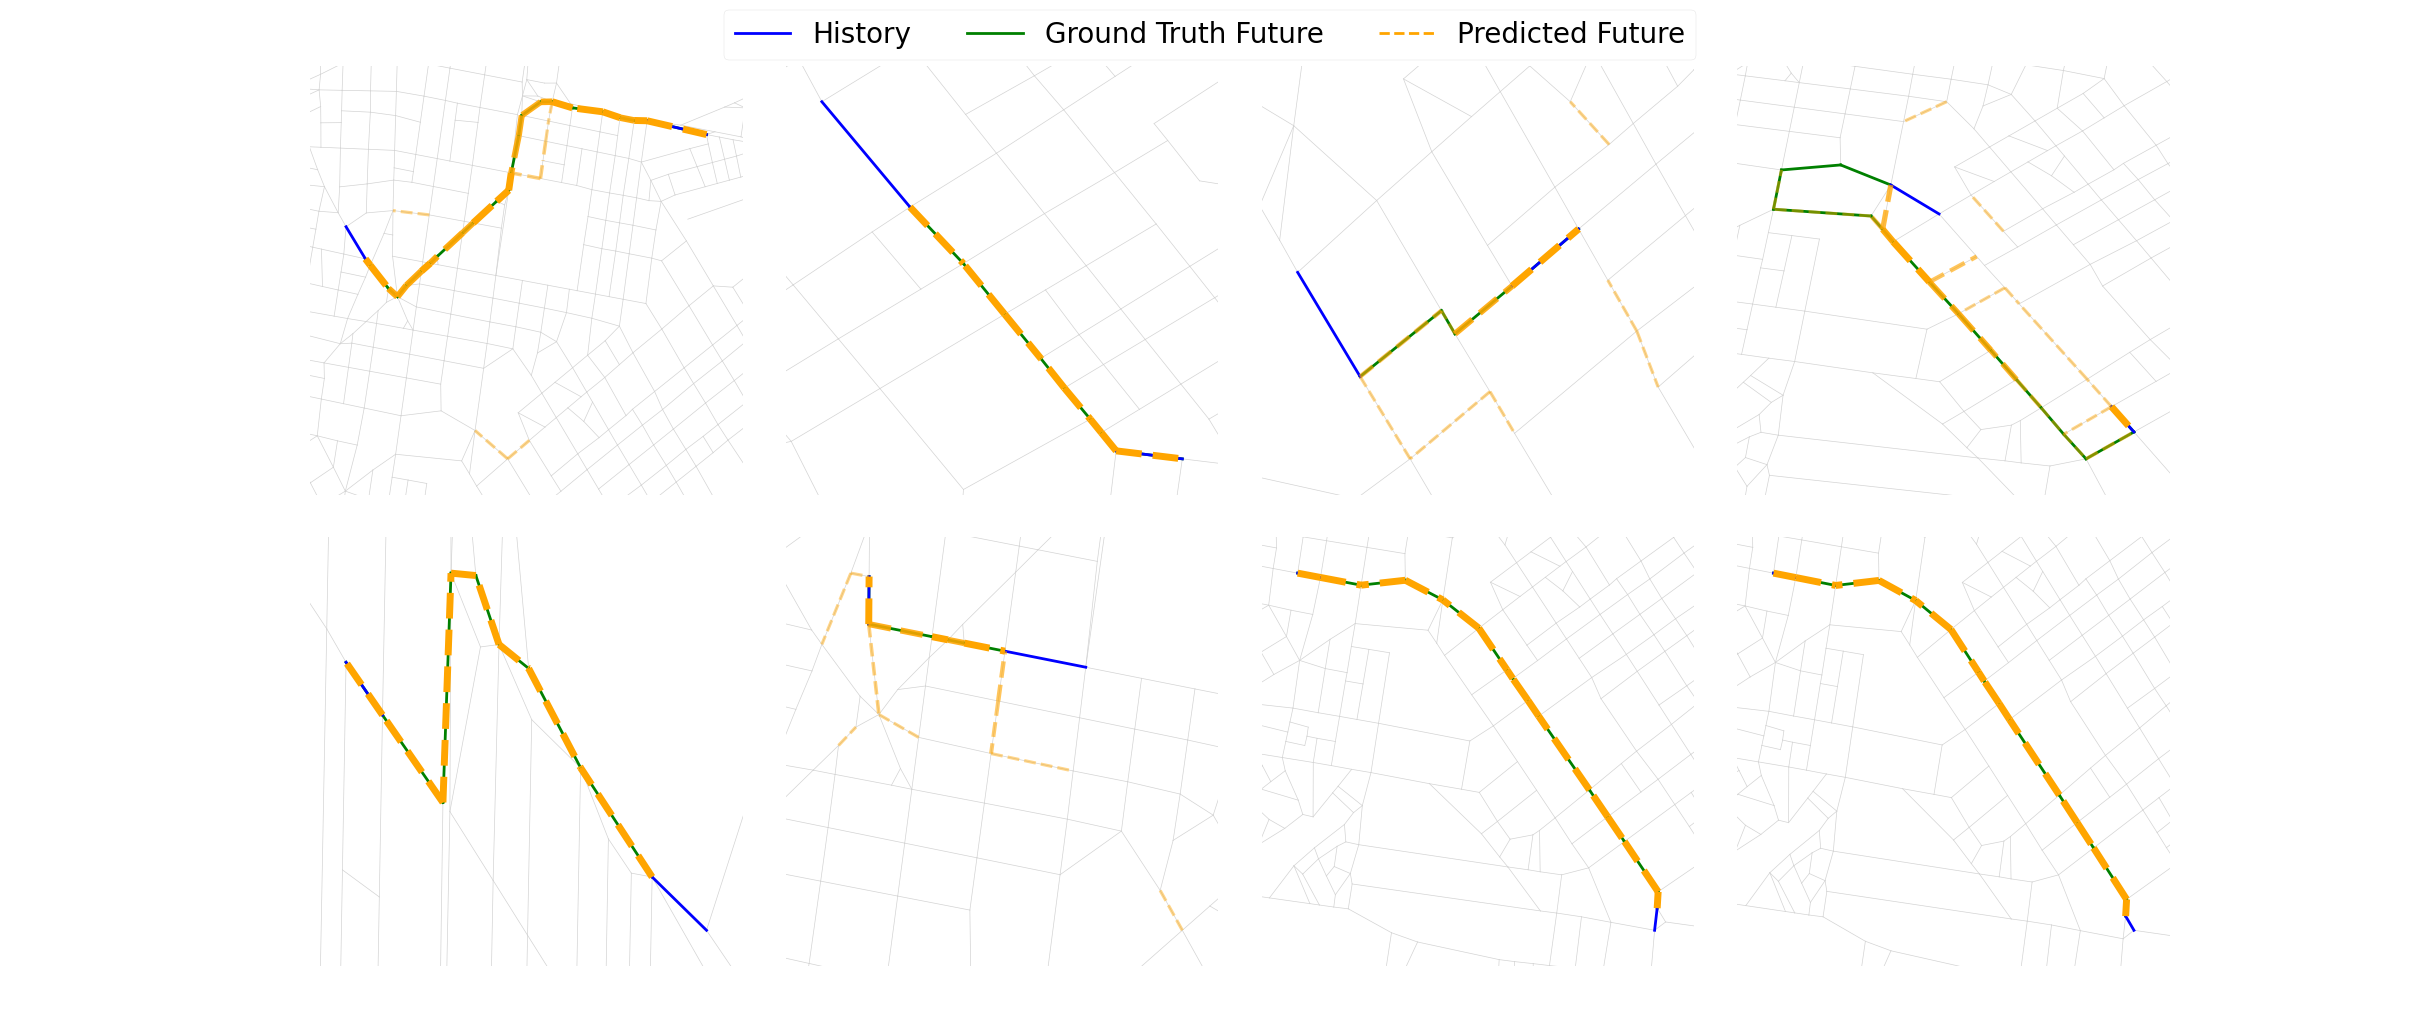

In [13]:
save_path = f'{folder}/{dataset}_{model}/{transition_matrix}_{noising}/output'
if not os.path.exists(save_path):
    os.makedirs(save_path)
save_path = save_path + f'/{features}_density_hist{history}_fut_{future}.png'
print("Saved at", save_path)
plot_path_density_random(res['ground_truth_hist'], res['ground_truth_fut'], res['samples_raw'], edge_coordinates, num_paths_to_plot=8, num_cols=4, num_rows=2, save_path=save_path, zoom_in=True)

## Plot Multiple Samples

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch

def plot_multiple_paths_random(ground_truth_hist, ground_truth_fut, samples, edge_coordinates, num_paths_to_plot=4, random=False, start_id=0, zoom_in=True):
    # Setup the subplot layout based on num_paths_to_plot
    fig, axs = plt.subplots(num_paths_to_plot, 1, figsize=(10, 5 * num_paths_to_plot), squeeze=False)
    axs = axs.flatten()  # Flatten in case of a single subplot to standardize indexing

    path_count = 0
    path_count = 0
    while path_count < num_paths_to_plot:
        batch_idx = torch.randint(0, len(ground_truth_hist), (1,)).item()
        idx = torch.randint(0, len(ground_truth_hist[batch_idx]), (1,)).item()
        
        ax = axs[path_count]
        if idx >= len(ground_truth_hist[batch_idx]):
            continue

        # Configure zooming in on relevant trajectories
        all_samples_edges = torch.cat([sample[idx] for sample in samples[batch_idx]])
        all_edges = torch.cat([ground_truth_hist[batch_idx][idx], ground_truth_fut[batch_idx][idx], all_samples_edges])
        if zoom_in:
            # all_edges = torch.cat([ground_truth_hist[batch_idx][idx], ground_truth_fut[batch_idx][idx]] + [sample[idx] for sample in samples[batch_idx]])
            if all_edges.numel() > 0:
                all_coords = edge_coordinates[all_edges].view(-1, 2)
                xmin, xmax = all_coords.min(0)[0], all_coords.max(0)[0]
                margin = (xmax - xmin) * 0.1
                xmin -= margin
                xmax += margin
                ax.set_xlim(xmin[0].item(), xmax[0].item())
                ax.set_ylim(xmin[1].item(), xmax[1].item())

        # Plot background edges
        for edge in edge_coordinates:
            ax.plot(edge[:, 0], edge[:, 1], color='grey', linewidth=0.5)

        # Define the plot_trajectory within this function to ensure it uses 'ax'
        def plot_trajectory(edge_indices, color, label):
            added_label = False  # Flag to add label only once
            if edge_indices.dim() == 2:
                edge_indices = edge_indices.squeeze(0)
            if edge_indices.numel() > 0:
                for edge_idx in edge_indices:
                    edge = edge_coordinates[edge_idx]
                    line_style = '-' if 'Predicted' in label else '-'  # Use dotted lines for 'Predicted Future'
                    lw = 4 if 'Predicted' in label else 2
                    alpha = 0.5 if 'Predicted' in label else 1
                    if not added_label:
                        ax.plot(edge[:, 0], edge[:, 1], color=color, linewidth=lw, linestyle=line_style, label=label)
                        added_label = True
                    else:
                        ax.plot(edge[:, 0], edge[:, 1], color=color, linewidth=lw, linestyle=line_style)

        plot_trajectory(ground_truth_hist[batch_idx][idx], 'blue', 'History')
        plot_trajectory(ground_truth_fut[batch_idx][idx], 'green', 'Ground Truth Future')
        
        # Plot all samples for this data point
        sample_colors = cm.get_cmap('tab10', len(samples[batch_idx]))
        for j, sample in enumerate(samples[batch_idx]):
            plot_trajectory(sample[idx], sample_colors(j), f'Predicted Future {j+1}')

        ax.set_title(f'Trajectory {idx+1} of batch {batch_idx+1}')
        ax.legend(loc='upper left')
        ax.axis('off')

        path_count += 1  # Increment the path counter

    plt.tight_layout()
    plt.show()

plot_multiple_paths_random(res['ground_truth_hist'], res['ground_truth_fut'], res['samples_raw'], edge_coordinates, num_paths_to_plot=10, zoom_in=True)

In [ ]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_paths_random(ground_truth_hist, ground_truth_fut, edge_coordinates,
                      num_paths_to_plot=4, zoom_in=True, save_path='trajectory_grid.png'):
    """
    Plots trajectories with full trajectory on the left and split trajectory on the right.

    Parameters:
    - ground_truth_hist: List of ground truth history edge indices.
    - ground_truth_fut: List of ground truth future edge indices.
    - edge_coordinates: Tensor of edge coordinates.
    - num_paths_to_plot: Number of trajectories to plot.
    - zoom_in: If True, zooms into the trajectory area.
    - save_path: File path to save the figure.
    """

    # Set the plotting style and parameters
    plt.style.use('seaborn-v0_8-paper')
    plt.rcParams.update({
        'axes.labelsize': 14,
        'axes.titlesize': 16,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 16,
        'axes.grid': False,
        'grid.alpha': 0.4,
        'lines.linewidth': 2,
    })

    num_cols = num_paths_to_plot
    num_rows = 2

    # Setup the subplot layout
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(6 * num_cols, 5 * num_rows))
    axs = np.array(axs)

    # Adjust layout to make room for the legend
    plt.subplots_adjust(top=0.95, bottom=0.05, wspace=0.1, hspace=0.1)

    for path_idx in range(num_paths_to_plot):
        batch_ids = [73, 83, 10]
        ids = [0, 0, 3]
        batch_idx = batch_ids[path_idx]
        idx = ids[path_idx]
        #batch_idx = torch.randint(0, len(ground_truth_hist), (1,)).item()
        #idx = torch.randint(0, len(ground_truth_hist[batch_idx]), (1,)).item()
        print("Batch", batch_idx, "Trajectory", idx)

        # Left subplot (full trajectory)
        ax_left = axs[0, path_idx]
        ax_left.cla()

        # Right subplot (split trajectory)
        ax_right = axs[1, path_idx]
        ax_right.cla()

        # Plot all edges as background with lighter color in both subplots
        for ax in [ax_left, ax_right]:
            for edge in edge_coordinates:
                ax.plot(edge[:, 0], edge[:, 1], color='lightgrey', linewidth=0.5, zorder=1)

        # Define the plot_trajectory function
        def plot_trajectory(ax, edge_indices, color, label, linestyle='-', lw=2, zorder=2):
            edge_indices = edge_indices[edge_indices >= 0]
            added_label = False  # Ensure label is added only once
            if edge_indices.dim() == 2:
                edge_indices = edge_indices.squeeze(0)
            if edge_indices.numel() > 0:
                for edge_idx in edge_indices:
                    edge = edge_coordinates[edge_idx]
                    if not added_label:
                        ax.plot(edge[:, 0], edge[:, 1], color=color, linewidth=lw, linestyle=linestyle,
                                label=label, zorder=zorder)
                        added_label = True
                    else:
                        ax.plot(edge[:, 0], edge[:, 1], color=color, linewidth=lw, linestyle=linestyle,
                                zorder=zorder)

        # Left subplot: Plot the full trajectory in light blue
        full_trajectory = torch.cat([ground_truth_hist[batch_idx][idx], ground_truth_fut[batch_idx][idx]])
        plot_trajectory(ax_left, full_trajectory, color='orange', label='Full Trajectory', lw=2)

        # Right subplot: Plot history and future separately
        plot_trajectory(ax_right, ground_truth_hist[batch_idx][idx], color='blue', label='History', lw=2)
        plot_trajectory(ax_right, ground_truth_fut[batch_idx][idx][:5], color='green', label='Future', lw=2)

        # Adjust zoom if needed
        if zoom_in:
            # Left subplot zoom
            all_edges_left = full_trajectory
            all_edges_left = all_edges_left[all_edges_left >= 0]
            if all_edges_left.numel() > 0:
                all_coords = edge_coordinates[all_edges_left].view(-1, 2)
                xmin, xmax = all_coords[:, 0].min(), all_coords[:, 0].max()
                ymin, ymax = all_coords[:, 1].min(), all_coords[:, 1].max()
                x_margin = (xmax - xmin) * 0.2
                y_margin = (ymax - ymin) * 0.2
                ax_left.set_xlim(xmin - x_margin, xmax + x_margin)
                ax_left.set_ylim(ymin - y_margin, ymax + y_margin)
            else:
                ax_left.set_xlim(edge_coordinates[:, :, 0].min(), edge_coordinates[:, :, 0].max())
                ax_left.set_ylim(edge_coordinates[:, :, 1].min(), edge_coordinates[:, :, 1].max())

            # Right subplot zoom
            all_edges_right = torch.cat([ground_truth_hist[batch_idx][idx], ground_truth_fut[batch_idx][idx]])
            all_edges_right = all_edges_right[all_edges_right >= 0]
            if all_edges_right.numel() > 0:
                all_coords = edge_coordinates[all_edges_right].view(-1, 2)
                xmin, xmax = all_coords[:, 0].min(), all_coords[:, 0].max()
                ymin, ymax = all_coords[:, 1].min(), all_coords[:, 1].max()
                x_margin = (xmax - xmin) * 0.2
                y_margin = (ymax - ymin) * 0.2
                ax_right.set_xlim(xmin - x_margin, xmax + x_margin)
                ax_right.set_ylim(ymin - y_margin, ymax + y_margin)
            else:
                ax_right.set_xlim(edge_coordinates[:, :, 0].min(), edge_coordinates[:, :, 0].max())
                ax_right.set_ylim(edge_coordinates[:, :, 1].min(), edge_coordinates[:, :, 1].max())
        else:
            # Set limits to the entire graph
            for ax in [ax_left, ax_right]:
                ax.set_xlim(edge_coordinates[:, :, 0].min(), edge_coordinates[:, :, 0].max())
                ax.set_ylim(edge_coordinates[:, :, 1].min(), edge_coordinates[:, :, 1].max())

        # Remove axes ticks and labels
        for ax in [ax_left, ax_right]:
            ax.set_xticks([])
            ax.set_yticks([])
            ax.axis('off')

    # Adjust the figure canvas to update positions
    fig.canvas.draw()

    # Create an extra axes that covers the entire figure for grid lines
    ax_grid = fig.add_axes([0, 0, 1, 1], frameon=False)
    ax_grid.set_xticks([])
    ax_grid.set_yticks([])
    ax_grid.set_xlim(0, 1)
    ax_grid.set_ylim(0, 1)

    # Collect positions for vertical lines (columns)
    x_positions = []
    for col in range(1, num_cols):
        pos = axs[0, col - 1].get_position()
        x_sep = pos.x1
        x_positions.append(x_sep)

    # Collect positions for horizontal lines (rows)
    y_positions = []
    for row in range(1, num_rows):
        pos = axs[row - 1, 0].get_position()
        y_sep = pos.y0
        y_positions.append(y_sep)

    # Draw vertical grid lines
    for x in x_positions:
        ax_grid.axvline(x=x + 0.005, color='lightgrey', linewidth=1)

    # Draw horizontal grid lines
    for y in y_positions:
        ax_grid.axhline(y=y - 0.005, color='lightgrey', linewidth=1)

    # Adjust layout and add legends
    handles_left, labels_left = axs[0, 0].get_legend_handles_labels()
    handles_right, labels_right = axs[1, 0].get_legend_handles_labels()

    # Combine handles and labels, ensuring uniqueness
    handles = handles_left + handles_right
    labels = labels_left + labels_right
    unique = dict(zip(labels, handles))

    fig.legend(unique.values(), unique.keys(), loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.02),
               frameon=True, fontsize=18)

    # Save and show the figure
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


In [ ]:
plot_paths_random(ground_truth_hist, ground_truth_fut, edge_coordinates,
                      num_paths_to_plot=3,
                      zoom_in=True, save_path='trajectory_grid.png')

In [ ]:
batch 73, idx 2
batch 83, idx 1
batch 10, idx, 3

PNEUMA (t=10, 20, 30, 40, 50, 60, 70, 80, 90, 100)

Partial Denoising (Prior)

In [6]:
hist_1 = [ 525,  521,  523,  481,  484]
hist_2 = [1050, 1028, 1035, 1284, 1041]
fut_1 = [ 475,  553,  555,  464,  465,  617,  620,  723,   46,   39]
fut_2 = [1046, 1101,  187,   59,  157, 1299,  161,   49]
samples_1_prior = [[203, 655, 881], #9
             [203, 226, 274, 343, 448, 700, 767, 1102, 1159, 1376], #19
             [202, 226, 274, 285, 343, 464, 806, 1159], #29
             [75, 226, 285, 464, 620, 1028, 1209], # 39
             [75, 464, 475, 620, 1028, 1209], # 49
             [75, 464, 465, 475, 553, 620, 777, 1028, 1209], # 59
             [75, 464, 465, 475, 553, 617, 620, 777, 1209], # 69
             [39, 46, 464, 465, 475, 554, 617, 620, 723, 777], # 79
             [39, 46, 464, 465, 475, 553, 555, 617, 620, 723, 777], # 89
             [39, 46, 464, 465, 475, 553, 555, 617, 620, 723, 777], # 99
             [39, 46, 464, 465, 475, 553, 555, 617, 620, 723, 777]  
             ]
samples_2_prior = [[120, 147, 297, 580, 955], # 9
             [120, 297, 402, 1104, 1126], # 19
             [59, 402, 686, 726, 1126], # 29
             [59, 154, 1046], # 39
             [59, 154, 1046], # 49
             [59, 154, 156, 1046], # 59
             [59, 154, 156, 1046, 1101], # 69
             [59, 154, 156, 1046, 1101], # 79
             [59, 154, 156, 1046, 1101], # 89
             [59, 154, 156, 187, 1046, 1101], # 99
             [59, 154, 156, 187, 1046, 1101]
             ]

Partial Denoising (Uniform)

In [7]:
samples_1_uniform = [[1,    3,    6,    8,   11,   16,   19,   21,   22,   23,   25,   27,
          28,   31,   32,   35,   39,   41,   42,   43,   44,   45,   50,   52,
          54,   55,   59,   60,   63,   64,   65,   66,   67,   68,   69,   71,
          72,   73,   74,   77,   81,   83,   84,   87,   88,   92,   93,   95,
          96,  100,  103,  105,  108,  109,  110,  113,  115,  116,  117,  119,
         122,  123,  124,  125,  135,  141,  143,  144,  147,  148,  150,  151,
         152,  153,  156,  161,  163,  164,  165,  166,  167,  168,  169,  171,
         174,  175,  176,  177,  178,  180,  181,  183,  186,  187,  190,  191,
         194,  195,  199,  204,  206,  211,  213,  214,  216,  217,  218,  221,
         222,  224,  225,  226,  227,  229,  231,  233,  234,  235,  241,  249,
         252,  257,  258,  259,  271,  275,  276,  277,  279,  280,  281,  284,
         285,  286,  287,  288,  290,  291,  292,  293,  296,  298,  299,  300,
         301,  305,  306,  308,  313,  314,  315,  320,  321,  322,  323,  326,
         328,  330,  333,  334,  337,  338,  339,  340,  342,  344,  345,  347,
         348,  349,  351,  352,  353,  354,  356,  358,  360,  361,  366,  368,
         369,  370,  373,  374,  376,  379,  380,  381,  382,  383,  394,  395,
         397,  398,  400,  401,  403,  405,  406,  407,  409,  410,  411,  413,
         415,  416,  418,  419,  422,  424,  427,  430,  431,  432,  435,  437,
         438,  440,  441,  446,  448,  449,  453,  455,  458,  459,  461,  463,
         464,  466,  467,  471,  472,  473,  474,  475,  477,  478,  479,  482,
         485,  486,  488,  490,  495,  498,  499,  500,  501,  502,  503,  506,
         507,  510,  511,  514,  516,  517,  521,  522,  526,  531,  532,  533,
         535,  536,  542,  544,  546,  547,  551,  553,  555,  559,  560,  562,
         564,  566,  567,  568,  570,  572,  573,  574,  575,  578,  580,  585,
         586,  587,  588,  589,  591,  592,  595,  596,  598,  599,  601,  603,
         604,  605,  607,  610,  611,  613,  615,  618,  619,  621,  624,  628,
         629,  632,  634,  635,  637,  642,  643,  646,  647,  648,  649,  654,
         655,  657,  658,  661,  662,  666,  668,  673,  676,  678,  679,  681,
         683,  684,  686,  691,  694,  696,  699,  700,  704,  706,  709,  711,
         713,  719,  721,  725,  727,  728,  731,  734,  736,  738,  739,  741,
         745,  752,  754,  755,  758,  759,  761,  765,  766,  767,  774,  775,
         777,  778,  780,  781,  782,  783,  784,  785,  786,  788,  795,  796,
         797,  801,  802,  803,  805,  806,  810,  811,  812,  813,  814,  815,
         820,  821,  822,  823,  825,  826,  827,  829,  830,  831,  832,  836,
         837,  839,  842,  844,  850,  851,  853,  854,  856,  859,  860,  861,
         862,  865,  866,  867,  873,  874,  876,  877,  879,  881,  882,  884,
         885,  886,  887,  888,  890,  891,  894,  897,  899,  900,  903,  904,
         908,  918,  919,  921,  923,  924,  927,  929,  931,  932,  933,  934,
         935,  938,  939,  940,  943,  945,  946,  950,  951,  953,  954,  958,
         960,  963,  964,  966,  970,  972,  974,  976,  977,  980,  981,  984,
         986,  990,  991,  996,  997,  999, 1000, 1001, 1003, 1004, 1005, 1008,
        1010, 1012, 1014, 1015, 1017, 1020, 1022, 1024, 1025, 1026, 1027, 1029,
        1030, 1031, 1033, 1034, 1035, 1038, 1039, 1040, 1041, 1042, 1044, 1045,
        1046, 1049, 1050, 1052, 1055, 1061, 1062, 1063, 1064, 1066, 1067, 1068,
        1069, 1070, 1072, 1075, 1076, 1078, 1081, 1083, 1086, 1090, 1091, 1098,
        1099, 1100, 1101, 1104, 1105, 1107, 1109, 1110, 1115, 1116, 1119, 1122,
        1126, 1130, 1132, 1133, 1136, 1138, 1141, 1142, 1144, 1145, 1146, 1148,
        1149, 1150, 1151, 1153, 1155, 1157, 1158, 1160, 1161, 1162, 1165, 1166,
        1167, 1168, 1169, 1170, 1171, 1172, 1174, 1175, 1176, 1179, 1180, 1182,
        1185, 1186, 1187, 1189, 1190, 1192, 1193, 1194, 1195, 1196, 1197, 1199,
        1207, 1209, 1212, 1213, 1215, 1216, 1221, 1222, 1223, 1224, 1225, 1226,
        1228, 1229, 1233, 1235, 1238, 1240, 1241, 1243, 1244, 1245, 1248, 1250,
        1251, 1253, 1256, 1257, 1258, 1259, 1261, 1262, 1267, 1268, 1271, 1272,
        1277, 1278, 1279, 1280, 1281, 1282, 1284, 1285, 1292, 1294, 1297, 1300,
        1301, 1302, 1303, 1305, 1306, 1307, 1314, 1317, 1319, 1320, 1323, 1324,
        1325, 1327, 1330, 1334, 1337, 1338, 1340, 1341, 1345, 1347, 1348, 1349,
        1350, 1351, 1353, 1360, 1365, 1368, 1369], [0,    1,    2,    3,    9,   11,   13,   15,   18,   19,   21,   22,
          23,   24,   25,   26,   28,   30,   31,   32,   38,   40,   43,   44,
          46,   48,   50,   52,   53,   55,   56,   58,   59,   61,   62,   63,
          64,   66,   68,   69,   71,   73,   82,   84,   87,   90,   92,   93,
          94,   95,   97,  100,  101,  105,  106,  107,  108,  110,  112,  118,
         121,  124,  125,  126,  128,  129,  130,  131,  134,  135,  137,  139,
         145,  146,  147,  148,  150,  153,  154,  156,  157,  158,  160,  162,
         163,  164,  166,  170,  171,  174,  176,  178,  179,  180,  181,  183,
         184,  186,  187,  189,  190,  191,  192,  193,  194,  195,  201,  207,
         208,  209,  211,  213,  215,  216,  217,  218,  221,  224,  225,  226,
         227,  228,  231,  233,  234,  236,  237,  240,  249,  253,  254,  257,
         259,  260,  268,  270,  271,  273,  275,  277,  278,  280,  286,  288,
         289,  292,  297,  299,  302,  306,  308,  310,  313,  315,  318,  320,
         322,  325,  326,  334,  338,  339,  340,  341,  344,  347,  348,  349,
         350,  352,  353,  356,  357,  358,  361,  362,  364,  365,  366,  367,
         368,  375,  376,  379,  381,  382,  385,  386,  391,  393,  395,  397,
         400,  401,  403,  411,  413,  416,  417,  421,  424,  426,  428,  435,
         437,  439,  440,  443,  448,  449,  450,  451,  453,  454,  458,  460,
         465,  468,  471,  472,  473,  474,  475,  476,  477,  479,  481,  482,
         485,  486,  487,  488,  489,  493,  495,  496,  499,  501,  502,  504,
         506,  509,  510,  511,  513,  514,  516,  519,  520,  522,  523,  524,
         527,  529,  531,  532,  534,  535,  537,  541,  542,  546,  547,  549,
         554,  560,  561,  563,  564,  566,  569,  571,  579,  580,  583,  588,
         589,  590,  593,  594,  595,  596,  597,  598,  599,  601,  604,  610,
         612,  616,  620,  622,  629,  632,  633,  636,  640,  641,  642,  643,
         644,  645,  649,  650,  652,  655,  656,  657,  661,  663,  665,  666,
         668,  669,  671,  672,  675,  678,  679,  681,  685,  686,  687,  689,
         690,  693,  694,  696,  697,  701,  703,  707,  712,  715,  716,  717,
         718,  721,  724,  727,  728,  731,  734,  738,  741,  742,  744,  745,
         747,  751,  753,  754,  757,  758,  759,  761,  762,  763,  764,  767,
         770,  771,  777,  781,  782,  783,  784,  787,  789,  790,  791,  793,
         794,  796,  797,  798,  804,  808,  810,  815,  817,  818,  819,  820,
         821,  823,  824,  825,  828,  830,  834,  837,  839,  842,  843,  845,
         847,  849,  850,  854,  856,  857,  859,  863,  867,  868,  871,  875,
         876,  878,  879,  884,  885,  892,  893,  894,  897,  899,  903,  904,
         906,  909,  913,  915,  916,  919,  920,  921,  922,  927,  928,  929,
         931,  934,  935,  936,  937,  940,  943,  946,  954,  955,  956,  957,
         959,  962,  965,  970,  971,  972,  973,  974,  976,  977,  982,  983,
         985,  986,  987,  991,  996,  997,  998,  999, 1000, 1002, 1004, 1005,
        1009, 1010, 1014, 1015, 1018, 1022, 1024, 1025, 1028, 1030, 1032, 1034,
        1036, 1037, 1038, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1051, 1052,
        1054, 1055, 1056, 1057, 1058, 1063, 1067, 1069, 1071, 1077, 1082, 1084,
        1090, 1093, 1096, 1099, 1102, 1104, 1107, 1108, 1109, 1110, 1111, 1112,
        1114, 1115, 1119, 1120, 1122, 1125, 1126, 1127, 1128, 1129, 1133, 1135,
        1137, 1139, 1140, 1141, 1143, 1144, 1147, 1148, 1149, 1150, 1151, 1152,
        1153, 1154, 1155, 1158, 1165, 1166, 1169, 1171, 1172, 1173, 1177, 1179,
        1183, 1184, 1186, 1187, 1194, 1196, 1197, 1200, 1203, 1206, 1207, 1208,
        1210, 1211, 1213, 1216, 1217, 1219, 1222, 1223, 1224, 1225, 1226, 1229,
        1230, 1234, 1235, 1236, 1237, 1239, 1240, 1241, 1243, 1245, 1249, 1250,
        1251, 1254, 1255, 1257, 1259, 1261, 1262, 1263, 1266, 1272, 1274, 1275,
        1278, 1279, 1283, 1286, 1289, 1291, 1292, 1293, 1294, 1295, 1296, 1297,
        1298, 1300, 1301, 1303, 1304, 1305, 1306, 1308, 1309, 1310, 1311, 1316,
        1318, 1319, 1324, 1326, 1332, 1337, 1338, 1339, 1340, 1341, 1344, 1345,
        1348, 1349, 1351, 1353, 1354, 1355, 1356, 1357, 1358, 1359, 1362, 1363,
        1366, 1367, 1368, 1372, 1373, 1375], [0,    1,    2,    3,    9,   11,   13,   15,   16,   19,   21,   22,
          23,   25,   26,   28,   29,   30,   36,   39,   40,   43,   45,   46,
          49,   50,   53,   55,   56,   57,   61,   64,   65,   66,   68,   69,
          73,   75,   81,   82,   84,   87,   88,   95,   96,   97,   98,   99,
         100,  105,  106,  107,  109,  113,  114,  116,  118,  120,  121,  122,
         124,  126,  128,  132,  135,  137,  138,  139,  143,  144,  146,  148,
         150,  152,  156,  158,  160,  162,  168,  170,  171,  172,  173,  174,
         183,  185,  188,  189,  191,  193,  196,  199,  202,  203,  205,  210,
         214,  216,  217,  218,  224,  225,  227,  228,  230,  231,  233,  234,
         236,  240,  242,  243,  246,  247,  248,  249,  251,  253,  254,  256,
         257,  259,  260,  265,  267,  268,  271,  274,  275,  278,  279,  281,
         282,  283,  286,  287,  297,  298,  300,  302,  305,  306,  308,  311,
         314,  315,  319,  322,  323,  325,  328,  330,  332,  333,  334,  335,
         338,  339,  340,  344,  348,  349,  350,  351,  353,  357,  358,  359,
         360,  362,  363,  365,  366,  370,  371,  372,  374,  375,  379,  381,
         383,  384,  385,  386,  387,  391,  392,  393,  394,  401,  402,  403,
         407,  411,  413,  415,  416,  417,  418,  419,  422,  424,  427,  436,
         439,  440,  443,  447,  448,  449,  450,  452,  453,  457,  458,  459,
         463,  470,  471,  477,  480,  481,  482,  483,  484,  486,  487,  488,
         493,  494,  495,  496,  497,  501,  502,  503,  506,  507,  508,  511,
         512,  513,  517,  518,  519,  521,  525,  527,  535,  537,  539,  541,
         542,  543,  545,  546,  547,  550,  555,  560,  561,  563,  564,  569,
         570,  571,  572,  577,  578,  579,  580,  582,  583,  585,  589,  590,
         591,  594,  595,  596,  598,  599,  600,  602,  605,  607,  610,  612,
         616,  620,  621,  622,  624,  625,  626,  636,  637,  639,  640,  641,
         642,  644,  647,  648,  654,  655,  656,  657,  662,  665,  667,  669,
         670,  673,  675,  676,  678,  680,  681,  683,  685,  686,  689,  690,
         692,  694,  696,  697,  701,  706,  712,  713,  716,  717,  718,  719,
         721,  723,  724,  728,  731,  732,  733,  734,  738,  741,  742,  743,
         744,  745,  746,  747,  750,  754,  755,  758,  759,  761,  762,  763,
         766,  767,  771,  773,  774,  775,  777,  778,  779,  781,  782,  784,
         786,  787,  789,  791,  794,  797,  798,  801,  802,  803,  805,  810,
         811,  815,  817,  818,  821,  822,  823,  824,  828,  831,  833,  834,
         837,  838,  841,  843,  844,  845,  846,  848,  850,  853,  855,  858,
         860,  862,  863,  865,  868,  869,  871,  873,  875,  876,  878,  879,
         880,  883,  884,  885,  889,  891,  892,  893,  897,  899,  900,  903,
         906,  907,  909,  911,  912,  914,  919,  920,  922,  928,  929,  931,
         933,  935,  936,  939,  940,  941,  943,  944,  946,  950,  951,  953,
         954,  959,  971,  973,  977,  980,  981,  982,  983,  984,  985,  987,
         989,  994,  996,  997,  998,  999, 1000, 1004, 1005, 1006, 1007, 1009,
        1016, 1018, 1022, 1025, 1026, 1028, 1030, 1031, 1032, 1036, 1037, 1038,
        1042, 1043, 1048, 1050, 1051, 1053, 1054, 1055, 1056, 1058, 1060, 1061,
        1067, 1068, 1069, 1071, 1074, 1075, 1078, 1080, 1081, 1082, 1083, 1085,
        1087, 1089, 1093, 1094, 1095, 1096, 1098, 1099, 1101, 1102, 1104, 1105,
        1107, 1108, 1110, 1111, 1114, 1119, 1120, 1123, 1125, 1127, 1129, 1130,
        1133, 1136, 1137, 1138, 1139, 1141, 1144, 1146, 1147, 1150, 1154, 1155,
        1157, 1159, 1161, 1162, 1166, 1169, 1172, 1173, 1177, 1180, 1183, 1187,
        1191, 1195, 1197, 1200, 1203, 1205, 1206, 1209, 1210, 1213, 1228, 1230,
        1231, 1232, 1233, 1234, 1235, 1236, 1239, 1241, 1243, 1245, 1248, 1251,
        1253, 1258, 1263, 1266, 1269, 1271, 1273, 1279, 1281, 1283, 1285, 1286,
        1289, 1291, 1293, 1294, 1297, 1298, 1302, 1303, 1304, 1305, 1306, 1308,
        1309, 1310, 1313, 1316, 1319, 1321, 1322, 1323, 1324, 1326, 1330, 1333,
        1336, 1337, 1339, 1340, 1341, 1344, 1347, 1348, 1351, 1352, 1353, 1355,
        1357, 1358, 1359, 1364, 1366, 1370, 1371, 1372, 1373, 1374, 1375], [0,    1,    4,    6,    8,    9,   10,   11,   15,   17,   19,   20,
          21,   22,   25,   29,   30,   31,   32,   34,   36,   39,   42,   43,
          45,   46,   48,   49,   50,   51,   55,   57,   58,   61,   64,   65,
          69,   70,   77,   81,   82,   84,   85,   86,   89,   92,   94,   96,
          97,   99,  103,  106,  107,  109,  110,  111,  114,  116,  117,  119,
         121,  122,  124,  126,  127,  128,  129,  130,  132,  134,  137,  138,
         139,  140,  144,  148,  151,  152,  154,  158,  160,  161,  162,  166,
         168,  169,  170,  171,  175,  176,  177,  182,  185,  186,  187,  188,
         191,  193,  196,  202,  204,  205,  206,  209,  214,  217,  221,  222,
         224,  227,  233,  234,  236,  240,  242,  243,  245,  247,  249,  251,
         252,  256,  257,  258,  261,  266,  267,  268,  271,  272,  276,  278,
         281,  283,  291,  292,  293,  300,  302,  306,  307,  308,  311,  313,
         315,  317,  319,  322,  323,  324,  327,  328,  329,  330,  331,  333,
         337,  343,  346,  348,  349,  351,  357,  360,  362,  363,  364,  366,
         369,  370,  371,  373,  374,  375,  376,  377,  379,  381,  385,  386,
         387,  391,  393,  394,  395,  399,  402,  403,  404,  405,  407,  408,
         409,  410,  411,  415,  417,  419,  424,  428,  429,  439,  440,  442,
         450,  456,  457,  458,  459,  461,  463,  466,  467,  470,  471,  473,
         474,  477,  479,  480,  481,  483,  487,  493,  496,  497,  498,  501,
         502,  503,  508,  511,  513,  518,  519,  520,  524,  529,  531,  532,
         533,  538,  541,  543,  544,  545,  552,  553,  555,  561,  564,  566,
         567,  570,  571,  577,  578,  579,  582,  583,  585,  590,  592,  596,
         597,  598,  599,  602,  603,  607,  608,  616,  617,  619,  622,  623,
         624,  626,  627,  628,  635,  636,  637,  638,  639,  640,  641,  644,
         645,  648,  649,  651,  652,  656,  658,  661,  662,  665,  667,  669,
         670,  671,  673,  678,  680,  681,  682,  685,  686,  687,  689,  690,
         692,  693,  694,  696,  702,  705,  709,  713,  715,  717,  718,  719,
         723,  727,  729,  732,  735,  736,  738,  741,  742,  746,  753,  754,
         755,  759,  772,  773,  775,  777,  778,  779,  783,  784,  785,  789,
         791,  792,  795,  796,  798,  801,  803,  805,  807,  818,  821,  822,
         828,  833,  834,  837,  839,  844,  846,  853,  855,  856,  858,  861,
         863,  867,  868,  869,  870,  871,  873,  875,  876,  877,  878,  882,
         884,  886,  887,  888,  889,  891,  892,  894,  897,  898,  900,  901,
         906,  907,  909,  910,  913,  914,  915,  918,  920,  921,  922,  923,
         929,  930,  931,  935,  936,  939,  941,  942,  944,  945,  946,  948,
         954,  957,  958,  960,  967,  969,  971,  972,  980,  982,  983,  985,
         988,  989,  994,  996,  998,  999, 1000, 1001, 1003, 1004, 1006, 1007,
        1010, 1012, 1016, 1018, 1022, 1025, 1028, 1030, 1031, 1032, 1034, 1036,
        1037, 1043, 1044, 1046, 1050, 1051, 1052, 1053, 1054, 1055, 1058, 1060,
        1061, 1064, 1067, 1068, 1071, 1072, 1073, 1080, 1081, 1082, 1083, 1084,
        1088, 1093, 1096, 1098, 1099, 1101, 1102, 1104, 1107, 1108, 1111, 1112,
        1119, 1120, 1123, 1127, 1129, 1131, 1133, 1136, 1139, 1140, 1141, 1142,
        1144, 1145, 1147, 1149, 1154, 1155, 1158, 1159, 1162, 1163, 1166, 1173,
        1177, 1183, 1186, 1187, 1189, 1191, 1195, 1197, 1198, 1201, 1202, 1203,
        1205, 1206, 1207, 1209, 1210, 1212, 1213, 1217, 1226, 1228, 1230, 1231,
        1232, 1234, 1235, 1243, 1245, 1247, 1248, 1249, 1250, 1251, 1253, 1256,
        1258, 1260, 1263, 1266, 1267, 1270, 1271, 1273, 1277, 1279, 1280, 1281,
        1285, 1287, 1289, 1291, 1294, 1296, 1297, 1298, 1299, 1301, 1303, 1305,
        1306, 1307, 1308, 1309, 1311, 1313, 1314, 1315, 1316, 1319, 1321, 1323,
        1324, 1329, 1330, 1331, 1333, 1336, 1339, 1341, 1343, 1347, 1348, 1352,
        1353, 1355, 1356, 1357, 1361, 1363, 1373, 1374, 1375], [0,    1,    2,    3,    6,   10,   15,   17,   19,   21,   22,   25,
          29,   30,   31,   34,   39,   40,   42,   43,   46,   50,   51,   57,
          64,   66,   69,   77,   82,   86,   89,   92,   94,   99,  107,  109,
         111,  116,  117,  119,  121,  124,  126,  127,  128,  129,  130,  132,
         138,  139,  140,  146,  148,  152,  158,  160,  161,  167,  168,  169,
         171,  175,  177,  182,  186,  188,  191,  193,  205,  206,  209,  212,
         214,  217,  222,  224,  233,  234,  235,  240,  242,  247,  249,  252,
         257,  258,  267,  268,  269,  271,  272,  276,  278,  283,  291,  292,
         293,  297,  300,  303,  313,  315,  317,  322,  323,  324,  327,  331,
         332,  333,  336,  340,  343,  345,  346,  347,  348,  349,  350,  353,
         354,  357,  360,  362,  363,  366,  369,  370,  371,  372,  373,  374,
         375,  376,  377,  378,  380,  390,  393,  395,  399,  403,  405,  411,
         413,  415,  419,  424,  429,  433,  439,  442,  446,  447,  449,  450,
         456,  458,  459,  461,  470,  471,  474,  477,  478,  479,  480,  483,
         484,  496,  498,  501,  503,  509,  515,  517,  518,  519,  524,  525,
         529,  531,  539,  540,  544,  545,  546,  552,  555,  565,  567,  568,
         570,  571,  574,  575,  577,  578,  579,  582,  585,  587,  591,  592,
         597,  601,  602,  603,  606,  608,  609,  613,  615,  616,  617,  618,
         621,  622,  624,  626,  627,  628,  629,  636,  639,  640,  643,  644,
         645,  649,  650,  651,  652,  655,  660,  661,  662,  665,  667,  668,
         670,  673,  678,  686,  687,  688,  689,  691,  692,  696,  704,  709,
         717,  718,  719,  723,  727,  729,  730,  732,  735,  741,  746,  747,
         753,  754,  756,  759,  764,  772,  773,  774,  777,  778,  783,  784,
         791,  796,  800,  801,  803,  807,  810,  812,  814,  816,  818,  819,
         821,  822,  824,  828,  833,  834,  837,  838,  839,  844,  847,  852,
         853,  854,  856,  858,  861,  863,  868,  870,  875,  878,  881,  882,
         884,  885,  886,  887,  888,  891,  897,  906,  907,  908,  913,  916,
         921,  922,  923,  927,  931,  936,  939,  940,  941,  946,  947,  948,
         957,  958,  960,  962,  964,  967,  971,  980,  981,  982,  987,  988,
         989,  996,  998, 1000, 1001, 1003, 1004, 1010, 1011, 1012, 1022, 1025,
        1030, 1031, 1032, 1036, 1043, 1044, 1045, 1051, 1053, 1055, 1056, 1058,
        1067, 1068, 1071, 1072, 1073, 1077, 1081, 1082, 1084, 1091, 1093, 1101,
        1102, 1104, 1107, 1108, 1111, 1112, 1116, 1120, 1121, 1123, 1124, 1128,
        1131, 1136, 1138, 1139, 1142, 1144, 1145, 1146, 1149, 1152, 1154, 1155,
        1160, 1163, 1164, 1166, 1172, 1173, 1175, 1180, 1186, 1190, 1191, 1197,
        1198, 1201, 1202, 1205, 1206, 1210, 1212, 1213, 1216, 1217, 1220, 1225,
        1227, 1228, 1230, 1238, 1245, 1246, 1251, 1252, 1253, 1256, 1258, 1259,
        1260, 1264, 1266, 1268, 1273, 1277, 1279, 1285, 1287, 1288, 1289, 1291,
        1294, 1301, 1303, 1305, 1306, 1307, 1313, 1315, 1316, 1318, 1319, 1321,
        1324, 1326, 1327, 1329, 1331, 1339, 1343, 1346, 1348, 1353, 1358, 1361,
        1363, 1364, 1369, 1370, 1374, 1375, 1376], [1,    2,    3,   16,   17,   21,   29,   30,   31,   34,   35,   40,
          42,   47,   53,   62,   64,   65,   66,   69,   70,   77,   82,   89,
          90,   92,   94,   95,  107,  116,  117,  119,  121,  129,  130,  139,
         140,  146,  152,  158,  160,  161,  167,  168,  169,  174,  175,  186,
         188,  190,  191,  193,  205,  206,  208,  212,  215,  217,  224,  226,
         233,  235,  237,  240,  247,  252,  267,  268,  269,  275,  293,  297,
         300,  302,  313,  315,  322,  324,  325,  326,  327,  331,  332,  340,
         342,  346,  349,  353,  357,  360,  361,  362,  369,  370,  372,  375,
         378,  385,  390,  393,  398,  399,  403,  414,  418,  419,  429,  431,
         433,  441,  442,  446,  447,  450,  456,  458,  459,  461,  464,  470,
         474,  478,  480,  483,  488,  492,  496,  501,  503,  508,  510,  517,
         518,  519,  521,  522,  538,  539,  548,  553,  555,  565,  569,  571,
         576,  577,  579,  585,  587,  589,  591,  595,  597,  601,  602,  603,
         605,  606,  613,  615,  617,  618,  620,  621,  622,  624,  639,  640,
         643,  649,  651,  655,  656,  660,  661,  665,  668,  670,  678,  686,
         687,  688,  689,  691,  692,  706,  709,  710,  718,  723,  729,  732,
         735,  741,  746,  747,  751,  759,  772,  773,  774,  778,  779,  780,
         782,  783,  791,  793,  796,  800,  801,  802,  804,  810,  812,  817,
         818,  819,  822,  824,  827,  828,  833,  837,  839,  852,  853,  854,
         856,  858,  861,  868,  875,  877,  878,  881,  882,  884,  885,  887,
         888,  889,  891,  896,  899,  906,  908,  916,  920,  922,  927,  929,
         931,  934,  935,  941,  946,  947,  948,  953,  957,  958,  960,  963,
         964,  971,  980,  987,  988,  989, 1000, 1005, 1006, 1010, 1011, 1012,
        1022, 1024, 1025, 1030, 1036, 1043, 1044, 1048, 1050, 1053, 1055, 1056,
        1058, 1064, 1072, 1075, 1081, 1082, 1084, 1087, 1090, 1091, 1093, 1094,
        1102, 1104, 1106, 1108, 1111, 1114, 1116, 1118, 1121, 1123, 1124, 1128,
        1131, 1142, 1144, 1145, 1149, 1155, 1160, 1164, 1166, 1169, 1172, 1173,
        1175, 1180, 1181, 1191, 1201, 1202, 1203, 1205, 1206, 1210, 1212, 1216,
        1217, 1225, 1226, 1227, 1228, 1230, 1242, 1245, 1248, 1252, 1256, 1258,
        1259, 1260, 1264, 1271, 1273, 1279, 1283, 1285, 1291, 1293, 1294, 1295,
        1303, 1305, 1314, 1315, 1316, 1319, 1324, 1326, 1339, 1343, 1346, 1352,
        1353, 1361, 1363, 1364, 1366, 1370, 1374], [3,   16,   17,   21,   30,   34,   35,   40,   42,   44,   51,
          53,   62,   65,   66,   69,   71,   82,   87,   89,   90,   94,   95,
          98,  107,  116,  119,  121,  130,  139,  140,  146,  158,  160,  167,
         169,  174,  188,  190,  191,  196,  199,  205,  206,  208,  217,  224,
         226,  233,  240,  247,  252,  267,  268,  275,  293,  302,  314,  315,
         325,  327,  332,  338,  340,  342,  349,  353,  357,  360,  372,  375,
         390,  393,  399,  403,  418,  419,  429,  442,  446,  447,  459,  462,
         464,  478,  480,  496,  508,  521,  522,  539,  544,  548,  553,  555,
         558,  565,  569,  571,  574,  577,  579,  589,  591,  595,  597,  601,
         603,  605,  613,  617,  618,  620,  621,  628,  633,  634,  635,  651,
         656,  660,  661,  665,  676,  678,  687,  688,  689,  710,  718,  723,
         724,  732,  735,  751,  759,  767,  778,  783,  791,  795,  796,  802,
         812,  817,  824,  833,  837,  839,  852,  854,  869,  870,  875,  877,
         878,  884,  889,  896,  899,  908,  916,  920,  922,  930,  931,  934,
         935,  941,  947,  953,  958,  971,  980,  987,  989, 1000, 1005, 1022,
        1024, 1025, 1030, 1036, 1037, 1043, 1048, 1053, 1055, 1056, 1058, 1063,
        1064, 1075, 1082, 1084, 1087, 1091, 1094, 1104, 1107, 1114, 1125, 1128,
        1142, 1155, 1164, 1169, 1173, 1175, 1180, 1181, 1202, 1203, 1206, 1210,
        1211, 1212, 1217, 1225, 1226, 1242, 1252, 1256, 1258, 1260, 1264, 1271,
        1285, 1291, 1292, 1293, 1294, 1305, 1307, 1314, 1319, 1324, 1326, 1335,
        1346, 1349, 1351, 1361, 1363, 1371], [3,   21,   30,   34,   35,   44,   62,   65,   87,   89,   94,   95,
          98,  139,  160,  169,  190,  196,  206,  217,  233,  240,  267,  301,
         306,  327,  338,  340,  343,  349,  360,  372,  390,  393,  419,  438,
         442,  446,  447,  459,  464,  465,  475,  478,  505,  517,  522,  530,
         553,  555,  565,  569,  577,  589,  591,  597,  617,  620,  628,  635,
         658,  661,  678,  688,  689,  723,  724,  732,  733,  751,  767,  770,
         791,  839,  875,  877,  878,  881,  884,  899,  916,  920,  929,  930,
         931,  937,  969,  971,  987, 1005, 1015, 1025, 1043, 1053, 1055, 1063,
        1075, 1082, 1084, 1094, 1107, 1124, 1142, 1181, 1185, 1202, 1203, 1206,
        1211, 1212, 1217, 1226, 1256, 1260, 1264, 1271, 1285, 1291, 1307, 1314,
        1318, 1324, 1326, 1346, 1351], [3,   21,   44,   65,   89,   94,   95,   98,  112,  160,  233,  327,
         349,  360,  390,  393,  419,  442,  464,  465,  475,  478,  553,  555,
         577,  588,  591,  617,  620,  688,  723,  791,  839,  877,  899,  920,
         930,  931,  971, 1053, 1063, 1084, 1107, 1202, 1206, 1211, 1256, 1260,
        1318], [44,   94,   95,  464,  465,  475,  553,  555,  617,  620,  723],
        [39, 44, 46, 464, 465, 475, 553, 555, 617, 620, 723, 777]]






samples_2_uniform = [[0,    2,    3,    4,    8,
           9,   10,   12,   13,   15,   16,   17,   21,   22,   26,   27,   29,
          31,   32,   33,   34,   35,   42,   44,   47,   49,   50,   51,   58,
          59,   60,   61,   65,   67,   71,   72,   73,   74,   75,   76,   77,
          78,   81,   82,   84,   88,   92,   93,   94,   95,   99,  101,  102,
         103,  106,  111,  114,  116,  117,  120,  124,  130,  131,  132,  134,
         135,  136,  137,  139,  141,  143,  146,  151,  153,  154,  155,  157,
         159,  160,  162,  165,  166,  168,  169,  171,  176,  177,  178,  179,
         180,  182,  184,  185,  187,  192,  193,  196,  198,  199,  203,  205,
         207,  210,  212,  213,  214,  217,  221,  224,  225,  228,  229,  231,
         232,  235,  239,  240,  243,  248,  249,  252,  257,  258,  260,  262,
         263,  268,  269,  270,  271,  272,  274,  276,  277,  281,  282,  283,
         284,  285,  289,  292,  296,  297,  298,  299,  302,  308,  310,  312,
         317,  318,  319,  320,  321,  323,  324,  329,  334,  337,  340,  341,
         342,  343,  346,  348,  351,  353,  355,  356,  358,  359,  360,  377,
         381,  382,  383,  384,  386,  389,  390,  392,  393,  394,  395,  399,
         404,  406,  408,  409,  410,  411,  412,  414,  416,  418,  420,  421,
         423,  425,  427,  428,  429,  433,  434,  438,  439,  446,  447,  449,
         450,  452,  453,  454,  456,  458,  459,  463,  470,  472,  474,  475,
         476,  477,  478,  479,  482,  483,  485,  486,  487,  488,  492,  493,
         494,  495,  498,  499,  501,  504,  505,  507,  508,  512,  513,  514,
         515,  516,  517,  518,  519,  520,  521,  522,  523,  525,  528,  534,
         536,  539,  541,  546,  548,  549,  552,  553,  555,  557,  560,  563,
         564,  565,  566,  567,  568,  569,  570,  573,  574,  575,  576,  577,
         580,  582,  583,  584,  587,  588,  589,  590,  591,  593,  597,  598,
         602,  605,  606,  607,  612,  613,  614,  616,  618,  620,  621,  625,
         626,  628,  629,  631,  632,  636,  637,  639,  640,  642,  647,  648,
         649,  650,  651,  652,  654,  656,  659,  662,  664,  665,  666,  668,
         669,  673,  675,  677,  678,  679,  680,  681,  686,  689,  690,  691,
         694,  695,  700,  702,  706,  707,  708,  709,  710,  711,  713,  714,
         715,  716,  718,  719,  720,  722,  725,  731,  732,  733,  734,  735,
         737,  738,  740,  743,  745,  747,  748,  750,  753,  755,  756,  757,
         758,  759,  762,  764,  769,  770,  771,  775,  776,  787,  789,  791,
         792,  795,  797,  798,  799,  800,  803,  805,  808,  812,  817,  818,
         819,  820,  822,  826,  827,  830,  831,  832,  833,  835,  837,  838,
         839,  840,  843,  844,  846,  849,  850,  853,  854,  858,  859,  860,
         865,  866,  868,  869,  872,  874,  879,  880,  881,  882,  884,  886,
         887,  889,  890,  895,  897,  898,  900,  901,  904,  905,  910,  914,
         915,  916,  918,  919,  920,  923,  927,  931,  933,  935,  939,  943,
         944,  945,  947,  951,  952,  954,  956,  958,  961,  964,  966,  968,
         969,  971,  972,  973,  974,  976,  978,  980,  982,  983,  984,  985,
         987,  991,  992,  993,  999, 1000, 1001, 1002, 1007, 1008, 1010, 1011,
        1012, 1019, 1021, 1023, 1025, 1027, 1030, 1031, 1032, 1034, 1036, 1039,
        1040, 1042, 1043, 1045, 1051, 1053, 1055, 1056, 1057, 1060, 1061, 1065,
        1067, 1069, 1070, 1076, 1078, 1079, 1081, 1083, 1085, 1086, 1087, 1088,
        1091, 1093, 1094, 1095, 1096, 1100, 1102, 1104, 1105, 1107, 1108, 1110,
        1113, 1115, 1116, 1118, 1119, 1120, 1121, 1122, 1124, 1125, 1126, 1128,
        1132, 1134, 1135, 1136, 1138, 1141, 1142, 1143, 1145, 1147, 1148, 1151,
        1152, 1153, 1155, 1157, 1158, 1159, 1162, 1167, 1170, 1171, 1172, 1174,
        1175, 1178, 1179, 1180, 1181, 1184, 1188, 1192, 1193, 1194, 1195, 1196,
        1197, 1198, 1199, 1200, 1201, 1204, 1206, 1207, 1208, 1209, 1210, 1211,
        1212, 1213, 1216, 1224, 1226, 1228, 1233, 1234, 1236, 1238, 1240, 1248,
        1250, 1253, 1256, 1258, 1259, 1261, 1263, 1264, 1265, 1266, 1272, 1274,
        1275, 1279, 1280, 1283, 1294, 1295, 1296, 1298, 1299, 1300, 1301, 1303,
        1304, 1305, 1306, 1309, 1310, 1312, 1313, 1314, 1317, 1319, 1321, 1322,
        1323, 1324, 1325, 1332, 1334, 1338, 1340, 1348, 1354, 1355, 1356, 1358,
        1359, 1366, 1372, 1373], [0,    2,    3,    4,    5,    6,
           7,    8,   10,   12,   13,   14,   16,   17,   19,   20,   21,   22,
          23,   26,   28,   31,   32,   33,   35,   36,   39,   40,   43,   44,
          48,   51,   52,   59,   60,   61,   64,   66,   67,   71,   72,   74,
          76,   77,   79,   80,   81,   82,   88,   89,   93,   97,   98,   99,
         101,  102,  103,  104,  107,  108,  111,  112,  114,  115,  116,  117,
         119,  124,  125,  128,  129,  130,  131,  133,  135,  137,  138,  139,
         141,  143,  144,  147,  148,  154,  155,  157,  160,  163,  164,  166,
         167,  168,  169,  171,  172,  175,  178,  181,  182,  184,  186,  187,
         191,  193,  198,  200,  203,  205,  206,  207,  211,  212,  213,  214,
         215,  217,  219,  220,  221,  223,  224,  225,  227,  228,  230,  231,
         232,  235,  236,  237,  239,  240,  245,  246,  250,  254,  256,  257,
         258,  259,  260,  262,  264,  265,  270,  274,  278,  280,  281,  284,
         285,  287,  288,  289,  291,  296,  297,  299,  300,  301,  304,  306,
         307,  309,  310,  317,  318,  321,  322,  329,  330,  332,  334,  336,
         337,  338,  340,  342,  343,  344,  346,  347,  348,  350,  353,  355,
         356,  357,  358,  359,  364,  366,  367,  369,  374,  376,  378,  381,
         383,  384,  385,  386,  388,  395,  398,  399,  401,  402,  404,  406,
         414,  415,  416,  421,  423,  424,  425,  427,  430,  431,  432,  433,
         434,  438,  439,  442,  444,  445,  448,  450,  452,  453,  454,  456,
         459,  461,  463,  465,  470,  471,  475,  476,  477,  478,  481,  482,
         485,  486,  489,  491,  492,  493,  494,  495,  496,  497,  498,  502,
         503,  505,  506,  507,  510,  512,  514,  515,  516,  518,  519,  520,
         521,  522,  524,  526,  528,  529,  532,  535,  537,  538,  542,  546,
         548,  549,  550,  552,  553,  557,  560,  563,  565,  566,  567,  568,
         570,  574,  575,  582,  583,  585,  588,  589,  590,  591,  592,  593,
         597,  598,  600,  601,  602,  603,  605,  607,  609,  611,  612,  615,
         624,  626,  628,  629,  631,  632,  634,  637,  638,  639,  642,  645,
         646,  648,  650,  652,  653,  655,  656,  658,  662,  665,  666,  667,
         668,  669,  672,  676,  679,  680,  682,  686,  687,  691,  693,  695,
         696,  702,  710,  711,  712,  713,  717,  719,  721,  722,  723,  724,
         729,  736,  737,  739,  743,  744,  747,  749,  751,  752,  753,  754,
         755,  756,  757,  760,  762,  763,  764,  765,  766,  767,  770,  771,
         772,  773,  774,  776,  778,  779,  781,  782,  786,  789,  791,  792,
         794,  797,  802,  804,  806,  810,  811,  812,  813,  814,  815,  817,
         818,  819,  821,  826,  829,  830,  831,  833,  834,  835,  837,  839,
         840,  843,  846,  847,  848,  850,  852,  854,  855,  857,  858,  861,
         864,  865,  868,  869,  870,  871,  874,  875,  877,  879,  880,  882,
         889,  891,  892,  895,  896,  898,  899,  900,  902,  903,  904,  905,
         906,  907,  908,  910,  911,  912,  913,  914,  916,  919,  920,  923,
         924,  925,  928,  929,  930,  931,  932,  934,  935,  936,  943,  944,
         945,  946,  947,  948,  950,  952,  953,  954,  957,  958,  962,  963,
         965,  966,  967,  969,  970,  973,  974,  975,  978,  985,  986,  987,
         988,  991,  992,  993,  994,  997,  998,  999, 1000, 1002, 1003, 1004,
        1005, 1006, 1007, 1010, 1014, 1016, 1017, 1019, 1020, 1022, 1023, 1024,
        1025, 1026, 1027, 1028, 1030, 1035, 1036, 1037, 1040, 1044, 1047, 1048,
        1050, 1051, 1054, 1055, 1059, 1060, 1061, 1064, 1065, 1066, 1067, 1068,
        1070, 1073, 1074, 1075, 1077, 1079, 1083, 1087, 1089, 1090, 1093, 1094,
        1097, 1098, 1101, 1103, 1104, 1106, 1107, 1112, 1114, 1115, 1117, 1120,
        1123, 1125, 1126, 1129, 1130, 1132, 1133, 1134, 1135, 1137, 1138, 1139,
        1141, 1142, 1143, 1144, 1147, 1148, 1151, 1152, 1155, 1156, 1158, 1163,
        1165, 1166, 1168, 1173, 1177, 1180, 1181, 1182, 1185, 1191, 1193, 1194,
        1195, 1196, 1198, 1200, 1201, 1202, 1203, 1204, 1208, 1209, 1210, 1211,
        1214, 1220, 1221, 1222, 1224, 1228, 1230, 1231, 1232, 1233, 1234, 1236,
        1237, 1238, 1239, 1240, 1241, 1242, 1243, 1244, 1248, 1249, 1250, 1260,
        1261, 1262, 1264, 1265, 1271, 1272, 1273, 1275, 1277, 1279, 1280, 1281,
        1283, 1285, 1287, 1291, 1292, 1293, 1296, 1297, 1299, 1301, 1302, 1304,
        1308, 1312, 1313, 1317, 1318, 1321, 1322, 1327, 1328, 1329, 1330, 1331,
        1333, 1340, 1346, 1347, 1348, 1353, 1354, 1360, 1361, 1362, 1364, 1365,
        1368, 1369, 1371, 1372, 1373, 1374, 1377], [3,
           6,    8,   10,   11,   12,   14,   15,   16,   18,   19,   20,   21,
          22,   24,   28,   30,   31,   32,   36,   41,   42,   44,   51,   52,
          53,   57,   59,   60,   63,   64,   66,   68,   69,   71,   76,   79,
          91,   95,   96,  100,  101,  102,  103,  105,  108,  109,  111,  112,
         114,  115,  118,  119,  121,  124,  126,  127,  128,  130,  131,  133,
         134,  135,  138,  140,  141,  142,  143,  144,  148,  149,  150,  151,
         153,  154,  156,  157,  159,  167,  168,  170,  171,  173,  175,  177,
         179,  180,  186,  189,  191,  193,  198,  201,  202,  203,  205,  206,
         210,  212,  217,  218,  219,  221,  222,  223,  225,  226,  227,  229,
         230,  231,  236,  237,  238,  245,  248,  249,  250,  254,  255,  257,
         259,  260,  262,  263,  264,  265,  267,  270,  272,  274,  276,  278,
         279,  280,  287,  294,  295,  297,  299,  300,  301,  302,  304,  306,
         308,  309,  313,  315,  320,  322,  326,  331,  332,  335,  337,  338,
         339,  340,  341,  342,  343,  344,  345,  346,  347,  350,  354,  356,
         357,  358,  359,  361,  364,  367,  372,  375,  376,  377,  381,  384,
         385,  387,  389,  393,  395,  396,  398,  400,  401,  402,  403,  404,
         406,  408,  410,  414,  415,  417,  419,  420,  421,  424,  428,  431,
         433,  434,  438,  439,  446,  447,  448,  450,  451,  453,  454,  456,
         458,  459,  461,  462,  463,  471,  473,  476,  477,  478,  481,  485,
         486,  488,  489,  490,  493,  494,  495,  498,  502,  503,  505,  506,
         508,  509,  510,  511,  513,  514,  515,  520,  521,  522,  526,  531,
         533,  535,  541,  543,  544,  545,  548,  550,  552,  554,  555,  558,
         560,  563,  565,  566,  569,  570,  571,  575,  576,  578,  579,  580,
         582,  583,  584,  585,  586,  587,  588,  590,  591,  592,  593,  594,
         597,  598,  599,  600,  601,  602,  603,  604,  605,  607,  608,  609,
         610,  613,  620,  624,  626,  628,  630,  631,  632,  634,  635,  636,
         638,  639,  642,  643,  644,  645,  648,  649,  650,  658,  662,  663,
         665,  666,  667,  668,  671,  672,  677,  681,  686,  687,  688,  691,
         695,  696,  699,  702,  707,  708,  711,  713,  714,  716,  719,  721,
         722,  728,  729,  734,  736,  739,  740,  741,  749,  753,  754,  755,
         756,  757,  758,  759,  762,  763,  765,  766,  767,  770,  772,  773,
         775,  776,  778,  779,  780,  784,  786,  787,  788,  789,  791,  794,
         796,  799,  803,  804,  806,  809,  811,  812,  813,  814,  816,  819,
         821,  824,  829,  830,  831,  832,  833,  834,  835,  837,  838,  839,
         840,  842,  843,  844,  847,  848,  850,  854,  856,  860,  861,  863,
         865,  866,  869,  870,  872,  874,  878,  879,  882,  883,  887,  889,
         891,  899,  900,  902,  904,  906,  908,  911,  913,  914,  915,  916,
         917,  919,  920,  921,  923,  924,  925,  926,  928,  930,  931,  932,
         934,  935,  938,  942,  948,  950,  952,  958,  960,  961,  965,  966,
         967,  969,  973,  977,  978,  979,  981,  986,  989,  991,  992,  993,
         995,  999, 1000, 1002, 1006, 1007, 1010, 1015, 1016, 1019, 1020, 1021,
        1026, 1027, 1028, 1030, 1032, 1033, 1036, 1040, 1042, 1044, 1045, 1048,
        1049, 1050, 1055, 1056, 1058, 1059, 1061, 1062, 1066, 1071, 1074, 1078,
        1089, 1091, 1093, 1094, 1096, 1103, 1105, 1108, 1111, 1113, 1114, 1115,
        1116, 1117, 1118, 1120, 1121, 1126, 1129, 1132, 1134, 1135, 1137, 1139,
        1140, 1142, 1144, 1145, 1148, 1149, 1151, 1152, 1155, 1158, 1163, 1164,
        1166, 1168, 1171, 1172, 1177, 1179, 1180, 1181, 1182, 1186, 1187, 1193,
        1196, 1197, 1198, 1202, 1203, 1205, 1207, 1209, 1210, 1211, 1214, 1215,
        1216, 1217, 1218, 1219, 1221, 1227, 1229, 1231, 1233, 1234, 1235, 1236,
        1237, 1240, 1245, 1246, 1248, 1249, 1250, 1251, 1255, 1259, 1264, 1265,
        1267, 1269, 1271, 1275, 1279, 1284, 1285, 1286, 1287, 1290, 1295, 1296,
        1297, 1299, 1301, 1302, 1303, 1304, 1307, 1312, 1317, 1319, 1320, 1323,
        1324, 1325, 1326, 1327, 1328, 1336, 1337, 1341, 1344, 1345, 1346, 1347,
        1350, 1351, 1355, 1356, 1357, 1358, 1359, 1360, 1361, 1362, 1365, 1368,
        1369, 1370, 1374, 1377], [3,    4,    6,
           8,    9,   11,   16,   19,   20,   21,   28,   29,   31,   32,   34,
          35,   36,   40,   41,   42,   43,   44,   51,   55,   57,   58,   59,
          60,   64,   66,   71,   76,   83,   85,   86,   90,   91,   95,   96,
          98,  101,  103,  106,  108,  109,  112,  115,  116,  119,  120,  121,
         124,  127,  128,  129,  130,  131,  133,  134,  135,  139,  141,  142,
         143,  146,  148,  149,  150,  152,  156,  157,  158,  160,  164,  165,
         167,  168,  170,  173,  174,  175,  176,  177,  178,  179,  180,  185,
         193,  198,  199,  202,  203,  205,  206,  207,  210,  214,  216,  218,
         219,  221,  222,  225,  228,  229,  231,  232,  235,  237,  238,  239,
         240,  245,  247,  248,  253,  257,  259,  260,  261,  263,  264,  267,
         270,  271,  273,  274,  277,  278,  279,  280,  283,  284,  294,  300,
         302,  304,  305,  308,  309,  310,  312,  313,  314,  315,  320,  323,
         332,  335,  338,  339,  340,  341,  344,  345,  351,  354,  356,  357,
         358,  362,  364,  367,  370,  372,  378,  379,  380,  381,  383,  384,
         386,  389,  390,  391,  393,  398,  400,  404,  405,  414,  415,  420,
         424,  426,  427,  428,  431,  433,  434,  437,  445,  446,  447,  448,
         456,  462,  463,  466,  471,  473,  474,  477,  478,  481,  482,  484,
         485,  486,  487,  489,  490,  492,  493,  498,  503,  504,  505,  508,
         509,  511,  512,  514,  519,  520,  526,  528,  532,  533,  534,  535,
         537,  541,  543,  545,  546,  547,  550,  552,  553,  555,  556,  558,
         560,  565,  566,  569,  571,  574,  575,  576,  577,  578,  582,  584,
         585,  586,  589,  590,  592,  594,  596,  597,  598,  600,  601,  603,
         604,  608,  610,  613,  614,  621,  622,  623,  627,  628,  631,  632,
         634,  638,  642,  644,  645,  649,  650,  651,  652,  660,  662,  668,
         671,  672,  675,  677,  681,  684,  686,  687,  688,  689,  691,  694,
         695,  696,  699,  702,  704,  707,  708,  709,  711,  714,  719,  723,
         727,  728,  730,  734,  736,  739,  740,  741,  745,  746,  753,  754,
         755,  756,  757,  759,  760,  763,  765,  767,  770,  772,  773,  775,
         776,  778,  779,  782,  783,  784,  786,  787,  790,  791,  794,  799,
         803,  806,  809,  810,  813,  814,  815,  816,  820,  821,  823,  824,
         828,  829,  830,  831,  832,  834,  835,  836,  837,  839,  843,  844,
         848,  852,  853,  854,  855,  856,  860,  861,  864,  865,  867,  868,
         870,  871,  872,  873,  876,  878,  880,  882,  883,  884,  887,  888,
         889,  890,  894,  896,  900,  902,  904,  908,  912,  913,  914,  916,
         919,  920,  924,  925,  926,  927,  930,  931,  934,  935,  936,  937,
         942,  943,  947,  949,  950,  952,  953,  957,  958,  965,  966,  967,
         969,  970,  971,  973,  981,  982,  986,  987,  989,  991,  993,  994,
         996,  997,  999, 1000, 1003, 1006, 1007, 1009, 1010, 1011, 1016, 1019,
        1021, 1025, 1026, 1027, 1028, 1030, 1032, 1037, 1038, 1040, 1042, 1046,
        1047, 1048, 1050, 1052, 1058, 1059, 1061, 1062, 1063, 1066, 1067, 1071,
        1081, 1084, 1085, 1089, 1090, 1091, 1096, 1098, 1101, 1103, 1105, 1107,
        1111, 1114, 1116, 1117, 1118, 1119, 1123, 1124, 1126, 1130, 1132, 1133,
        1135, 1138, 1140, 1141, 1142, 1144, 1145, 1149, 1152, 1157, 1158, 1164,
        1166, 1169, 1170, 1172, 1175, 1177, 1179, 1180, 1182, 1183, 1184, 1185,
        1186, 1187, 1188, 1191, 1193, 1194, 1197, 1198, 1202, 1203, 1204, 1206,
        1207, 1208, 1209, 1216, 1218, 1226, 1227, 1229, 1233, 1235, 1236, 1237,
        1239, 1242, 1246, 1250, 1251, 1256, 1257, 1261, 1264, 1265, 1267, 1269,
        1270, 1272, 1273, 1275, 1278, 1279, 1280, 1282, 1284, 1285, 1287, 1289,
        1296, 1297, 1301, 1302, 1303, 1305, 1307, 1310, 1312, 1314, 1316, 1317,
        1319, 1323, 1325, 1326, 1328, 1329, 1330, 1335, 1336, 1337, 1338, 1341,
        1344, 1345, 1346, 1347, 1350, 1351, 1356, 1357, 1358, 1360, 1368, 1369,
        1373, 1374, 1377], [3,    6,    8,   11,   12,
          13,   14,   15,   16,   19,   20,   21,   26,   28,   29,   30,   31,
          35,   36,   39,   41,   42,   43,   44,   45,   47,   50,   51,   53,
          58,   59,   60,   64,   66,   68,   71,   76,   83,   85,   86,   89,
          91,   95,   96,   97,   99,  100,  101,  103,  106,  107,  108,  109,
         116,  119,  120,  121,  128,  129,  130,  134,  136,  140,  141,  142,
         143,  144,  148,  149,  150,  151,  152,  153,  155,  156,  160,  165,
         167,  168,  173,  174,  175,  176,  177,  180,  187,  193,  197,  198,
         199,  202,  203,  205,  206,  207,  210,  212,  214,  215,  218,  221,
         222,  225,  228,  231,  232,  235,  237,  238,  239,  240,  242,  245,
         247,  248,  249,  253,  255,  257,  260,  261,  263,  264,  266,  267,
         270,  271,  274,  278,  280,  284,  294,  300,  304,  305,  307,  308,
         309,  310,  313,  314,  315,  319,  325,  328,  335,  338,  339,  340,
         345,  350,  351,  354,  357,  358,  362,  364,  367,  370,  377,  378,
         381,  383,  386,  393,  398,  399,  402,  404,  405,  406,  408,  411,
         412,  414,  415,  416,  423,  424,  426,  431,  434,  439,  440,  441,
         442,  446,  448,  463,  466,  469,  471,  474,  475,  476,  477,  481,
         482,  484,  485,  486,  487,  492,  498,  503,  504,  507,  508,  509,
         511,  512,  514,  519,  520,  524,  526,  528,  529,  532,  535,  543,
         546,  547,  552,  555,  556,  558,  560,  562,  565,  566,  569,  574,
         575,  576,  577,  578,  579,  583,  585,  590,  592,  596,  597,  600,
         604,  608,  610,  612,  613,  614,  615,  617,  621,  622,  624,  628,
         630,  632,  633,  647,  648,  650,  651,  658,  660,  665,  666,  668,
         671,  672,  675,  677,  684,  687,  688,  691,  695,  696,  699,  701,
         702,  704,  707,  708,  709,  710,  711,  714,  719,  720,  723,  724,
         730,  738,  739,  740,  742,  744,  745,  752,  753,  754,  755,  759,
         760,  762,  763,  767,  770,  772,  776,  777,  779,  782,  783,  784,
         786,  787,  790,  791,  794,  799,  806,  809,  810,  811,  813,  815,
         820,  823,  824,  826,  828,  829,  830,  831,  833,  834,  835,  841,
         842,  843,  844,  845,  848,  850,  851,  852,  854,  855,  856,  859,
         860,  861,  864,  868,  870,  872,  873,  876,  878,  879,  884,  885,
         887,  889,  891,  893,  894,  896,  900,  902,  904,  905,  908,  909,
         910,  912,  913,  914,  920,  923,  924,  927,  930,  931,  934,  935,
         936,  937,  942,  947,  949,  950,  951,  953,  954,  958,  966,  969,
         970,  971,  973,  975,  980,  981,  982,  986,  988,  989,  990,  991,
         992,  993,  998, 1000, 1005, 1007, 1011, 1015, 1016, 1017, 1019, 1021,
        1025, 1027, 1028, 1032, 1034, 1037, 1038, 1039, 1041, 1044, 1048, 1049,
        1050, 1051, 1052, 1055, 1059, 1063, 1066, 1067, 1069, 1071, 1075, 1079,
        1080, 1081, 1084, 1085, 1089, 1090, 1091, 1094, 1096, 1098, 1101, 1103,
        1105, 1112, 1114, 1117, 1118, 1121, 1123, 1124, 1130, 1133, 1134, 1135,
        1136, 1138, 1140, 1144, 1145, 1149, 1150, 1152, 1155, 1158, 1161, 1164,
        1166, 1169, 1172, 1176, 1178, 1179, 1180, 1183, 1184, 1187, 1188, 1191,
        1192, 1193, 1194, 1196, 1197, 1198, 1201, 1202, 1203, 1204, 1207, 1208,
        1209, 1212, 1214, 1216, 1218, 1223, 1226, 1229, 1235, 1236, 1237, 1238,
        1239, 1241, 1242, 1243, 1251, 1256, 1257, 1259, 1264, 1265, 1266, 1267,
        1269, 1273, 1276, 1278, 1279, 1282, 1284, 1286, 1287, 1288, 1289, 1296,
        1297, 1301, 1302, 1303, 1310, 1312, 1314, 1317, 1322, 1326, 1328, 1329,
        1336, 1337, 1340, 1341, 1344, 1346, 1347, 1350, 1351, 1354, 1356, 1357,
        1367, 1368, 1377], [3,    6,    8,   11,   16,
          19,   20,   22,   26,   30,   31,   35,   36,   41,   42,   43,   44,
          45,   49,   50,   51,   52,   54,   58,   59,   60,   64,   68,   83,
          85,   88,   89,   91,   95,   96,   97,   99,  100,  103,  106,  107,
         108,  109,  116,  119,  120,  121,  125,  129,  130,  134,  136,  141,
         142,  148,  149,  151,  152,  153,  157,  165,  168,  174,  175,  177,
         180,  187,  193,  202,  205,  206,  207,  210,  212,  215,  218,  221,
         222,  225,  228,  231,  232,  235,  237,  238,  240,  245,  257,  261,
         263,  271,  274,  280,  284,  293,  304,  305,  307,  309,  310,  312,
         313,  314,  316,  324,  325,  328,  335,  338,  339,  340,  341,  344,
         345,  346,  350,  357,  358,  362,  365,  367,  377,  381,  383,  387,
         388,  393,  398,  402,  407,  408,  409,  411,  412,  414,  421,  422,
         423,  426,  431,  434,  439,  442,  446,  459,  462,  463,  466,  469,
         474,  477,  481,  483,  486,  487,  498,  503,  509,  511,  512,  520,
         535,  539,  540,  547,  552,  556,  557,  560,  562,  565,  566,  572,
         575,  578,  579,  580,  583,  590,  596,  597,  604,  605,  608,  610,
         612,  613,  614,  617,  621,  622,  623,  624,  628,  630,  632,  648,
         651,  661,  664,  668,  671,  672,  675,  677,  679,  680,  683,  688,
         691,  696,  701,  702,  703,  704,  707,  709,  710,  711,  715,  716,
         719,  723,  724,  730,  736,  738,  739,  740,  745,  753,  755,  759,
         760,  772,  773,  774,  776,  781,  782,  786,  790,  794,  806,  810,
         811,  813,  815,  818,  826,  828,  829,  830,  831,  833,  834,  843,
         845,  848,  852,  856,  861,  864,  865,  867,  870,  873,  874,  876,
         879,  884,  885,  887,  891,  893,  894,  896,  900,  905,  913,  920,
         923,  924,  927,  930,  931,  934,  936,  937,  938,  947,  950,  951,
         953,  958,  964,  971,  974,  975,  977,  981,  982,  986,  987,  989,
         990,  991,  995,  998, 1014, 1016, 1017, 1019, 1022, 1025, 1027, 1034,
        1036, 1037, 1039, 1041, 1046, 1048, 1050, 1051, 1052, 1059, 1063, 1066,
        1067, 1072, 1080, 1081, 1085, 1087, 1091, 1095, 1096, 1098, 1101, 1103,
        1105, 1114, 1117, 1121, 1123, 1124, 1130, 1138, 1149, 1150, 1152, 1155,
        1158, 1161, 1164, 1169, 1176, 1180, 1184, 1187, 1188, 1189, 1191, 1192,
        1193, 1197, 1198, 1201, 1202, 1203, 1204, 1205, 1214, 1216, 1223, 1225,
        1226, 1229, 1236, 1238, 1239, 1241, 1242, 1255, 1256, 1257, 1265, 1269,
        1278, 1287, 1288, 1295, 1296, 1297, 1301, 1302, 1309, 1310, 1314, 1322,
        1338, 1340, 1350, 1351, 1355, 1356, 1357, 1368], [11,   16,   17,   19,   20,   22,
          23,   30,   33,   35,   36,   41,   42,   43,   44,   45,   49,   51,
          52,   53,   58,   59,   60,   68,   76,   83,   85,   88,   91,   99,
         103,  106,  107,  108,  113,  114,  116,  119,  120,  127,  129,  136,
         139,  141,  149,  153,  157,  163,  165,  174,  177,  187,  192,  205,
         207,  212,  218,  232,  235,  238,  245,  253,  257,  260,  261,  263,
         274,  280,  287,  290,  293,  304,  305,  309,  310,  312,  313,  316,
         317,  323,  325,  328,  339,  340,  341,  343,  345,  346,  350,  358,
         365,  367,  375,  377,  379,  381,  383,  390,  398,  408,  409,  411,
         412,  414,  421,  422,  430,  439,  459,  466,  469,  474,  477,  481,
         483,  487,  498,  503,  520,  535,  539,  544,  547,  556,  568,  572,
         578,  596,  597,  604,  605,  610,  617,  621,  622,  623,  624,  628,
         632,  637,  640,  651,  656,  666,  671,  675,  678,  683,  688,  689,
         696,  701,  702,  704,  706,  707,  709,  724,  730,  736,  737,  738,
         739,  745,  760,  772,  776,  781,  782,  790,  794,  806,  811,  815,
         826,  829,  831,  833,  839,  845,  848,  852,  856,  865,  867,  870,
         873,  874,  876,  887,  891,  893,  894,  896,  898,  900,  913,  920,
         924,  926,  934,  938,  943,  950,  951,  954,  958,  977,  981,  982,
         986,  987,  989,  990,  991,  995, 1002, 1005, 1017, 1022, 1025, 1030,
        1036, 1037, 1039, 1046, 1050, 1051, 1052, 1056, 1063, 1066, 1087, 1091,
        1095, 1096, 1097, 1098, 1101, 1103, 1105, 1114, 1121, 1130, 1132, 1140,
        1144, 1152, 1161, 1162, 1163, 1164, 1169, 1171, 1180, 1184, 1188, 1189,
        1192, 1197, 1198, 1201, 1203, 1205, 1216, 1226, 1229, 1236, 1238, 1242,
        1244, 1255, 1257, 1278, 1287, 1296, 1297, 1301, 1308, 1309, 1310, 1327,
        1340, 1355, 1356, 1357, 1373, 1374, 1375], [17,   19,   20,   42,   43,   49,   53,
          59,   68,   73,   83,   88,   91,   99,  106,  107,  108,  113,  116,
         127,  129,  139,  153,  157,  165,  174,  177,  187,  192,  212,  213,
         235,  238,  245,  260,  280,  293,  310,  317,  321,  323,  346,  367,
         379,  381,  383,  390,  398,  411,  422,  430,  462,  466,  469,  477,
         481,  487,  491,  503,  520,  544,  556,  572,  580,  597,  615,  617,
         621,  628,  637,  640,  656,  675,  683,  688,  701,  702,  704,  709,
         724,  745,  758,  760,  776,  781,  790,  794,  798,  806,  811,  829,
         831,  839,  848,  852,  865,  870,  876,  882,  893,  894,  896,  913,
         926,  980,  981,  982,  987,  990, 1017, 1022, 1025, 1035, 1036, 1046,
        1052, 1056, 1063, 1087, 1095, 1096, 1098, 1101, 1103, 1133, 1152, 1154,
        1161, 1162, 1163, 1179, 1184, 1186, 1188, 1197, 1203, 1205, 1216, 1226,
        1255, 1257, 1278, 1282, 1287, 1296, 1308, 1309, 1310, 1340, 1343, 1354,
        1355, 1357, 1366, 1373, 1375], [19,   49,   59,   88,   91,   99,  106,  107,  108,  129,  153,
         157,  177,  187,  235,  238,  293,  411,  487,  615,  637,  640,  704,
         758,  781,  790,  806,  811,  829,  852,  913,  982, 1017, 1022, 1036,
        1046, 1087, 1101, 1133, 1154, 1179, 1203, 1205, 1255, 1354, 1355], [59,
          88,   91,   99,  106,  153,  157,  187, 1046, 1101],
        [1046, 1101,  187,   59,  157, 1299,  161,   49, 88]]

In [13]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_paths_random(ground_truth_hist, ground_truth_fut, samples, edge_coordinates,
                      num_paths_to_plot=2, zoom_in=True, save_path='trajectory_grid.png'):
    """
    Plots trajectories with a column for each trajectory displaying 10 samples.

    Parameters:
    - ground_truth_hist: List of lists of ground truth history edge indices.
    - ground_truth_fut: List of lists of ground truth future edge indices.
    - samples: List of lists of lists containing 10 samples of predicted trajectories.
    - edge_coordinates: Tensor of edge coordinates.
    - num_paths_to_plot: Number of trajectories to plot.
    - zoom_in: If True, zooms into the trajectory area.
    - save_path: File path to save the figure.
    """

    # Set the plotting style and parameters
    plt.style.use('seaborn-v0_8-paper')
    plt.rcParams.update({
        'axes.labelsize': 14,
        'axes.titlesize': 14,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 11,
        'axes.grid': False,
        'grid.alpha': 0.4,
        'lines.linewidth': 2,
    })

    # Calculate the number of subplots needed
    num_cols = 2  # All trajectories in one column
    num_rows = 6  # 10 samples per trajectory

    # Setup the subplot layout
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(8, 2.3 * num_rows))

    # Adjust layout to make room for the legend
    plt.subplots_adjust(top=0.96, bottom=0.0, wspace=0.2, hspace=0.05)

    # Plot each sample for each trajectory
    for path_idx in range(num_paths_to_plot):
        for i, sample_idx in enumerate(range(0, 11, 2)):
            ax = axs[i, path_idx]
            ax.cla()

            # Background edges
            for edge in edge_coordinates:
                ax.plot(edge[:, 0], edge[:, 1], color='lightgrey', linewidth=0.5, zorder=1)

            # Define the plot_trajectory function
            def plot_trajectory(ax, edge_indices, color, label, linestyle='-', lw=2, zorder=2):
                edge_indices = edge_indices[edge_indices >= 0]
                added_label = False  # Ensure label is added only once
                if edge_indices.dim() == 2:
                    edge_indices = edge_indices.squeeze(0)
                if edge_indices.numel() > 0:
                    for edge_idx in edge_indices:
                        edge = edge_coordinates[edge_idx]
                        if not added_label:
                            ax.plot(edge[:, 0], edge[:, 1], color=color, linewidth=lw, linestyle=linestyle,
                                    label=label, zorder=zorder)
                            added_label = True
                        else:
                            ax.plot(edge[:, 0], edge[:, 1], color=color, linewidth=lw, linestyle=linestyle,
                                    zorder=zorder)


            # Plot the history and future
            history = torch.tensor(ground_truth_hist[path_idx])
            future = torch.tensor(ground_truth_fut[path_idx])
            plot_trajectory(ax, history, color='blue', label='History', lw=2)
            plot_trajectory(ax, future, color='green', label='Future', lw=2)
            # Plot the samples
            sample_trajectory = torch.tensor(samples[path_idx][sample_idx])
            plot_trajectory(ax, sample_trajectory, color='orange', label='Sampled Edges', linestyle='-', lw=3)

            # Zoom into the trajectory area
            if zoom_in:
                all_edges = torch.cat([history, future, sample_trajectory])
                all_edges = all_edges[all_edges >= 0]
                if all_edges.numel() > 0:
                    all_coords = edge_coordinates[all_edges].view(-1, 2)
                    xmin, xmax = all_coords[:, 0].min(), all_coords[:, 0].max()
                    ymin, ymax = all_coords[:, 1].min(), all_coords[:, 1].max()
                    x_margin = (xmax - xmin) * 0.2
                    y_margin = (ymax - ymin) * 0.2
                    ax.set_xlim(xmin - x_margin, xmax + x_margin)
                    ax.set_ylim(ymin - y_margin, ymax + y_margin)
                else:
                    ax.set_xlim(edge_coordinates[:, :, 0].min(), edge_coordinates[:, :, 0].max())
                    ax.set_ylim(edge_coordinates[:, :, 1].min(), edge_coordinates[:, :, 1].max())

            # Remove axes ticks and labels
            ax.set_xticks([])
            ax.set_yticks([])
            ax.axis('off')
            
            t = 100 - 10 * sample_idx
            ax.annotate(f"t = {t}", xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, color='black',
                        verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor='gray', facecolor='white', alpha=0.5))

        
        ax_grid = fig.add_axes([0, 0, 1, 1], frameon=False)
        ax_grid.set_xticks([])
        ax_grid.set_yticks([])
        ax_grid.set_xlim(0, 1)
        ax_grid.set_ylim(0, 1)
        
        # Collect positions for vertical lines (columns)
        x_positions = []
        for col in range(1, num_cols):
            pos = axs[0, col - 1].get_position()
            x_sep = pos.x1
            x_positions.append(x_sep)

        # Collect positions for horizontal lines (rows)
        y_positions = []
        for row in range(1, num_rows):
            pos = axs[row - 1, 0].get_position()
            y_sep = pos.y0
            y_positions.append(y_sep)

        # Draw vertical grid lines
        for x in x_positions:
            ax_grid.axvline(x=x+0.035, color='lightgrey', linewidth=1)

        # Draw horizontal grid lines
        for y in y_positions:
            ax_grid.axhline(y=y, color='lightgrey', linewidth=1)

    # Draw grid lines and add legends
    handles, labels = ax.get_legend_handles_labels()
    unique = dict(zip(labels, handles))
    fig.legend(unique.values(), unique.keys(), loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.02),
               frameon=True, fontsize=11)

    # Save and show the figure
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


In [14]:
'''ground_truth_hist = [hist_1, hist_2]
ground_truth_fut = [fut_1, fut_2]
samples = [samples_1_prior, samples_2_prior]
plot_paths_random(ground_truth_hist, ground_truth_fut, samples, edge_coordinates,
                      num_paths_to_plot=2, zoom_in=False, save_path='partial_denoising.png')'''

"ground_truth_hist = [hist_1, hist_2]\nground_truth_fut = [fut_1, fut_2]\nsamples = [samples_1_prior, samples_2_prior]\nplot_paths_random(ground_truth_hist, ground_truth_fut, samples, edge_coordinates,\n                      num_paths_to_plot=2, zoom_in=False, save_path='partial_denoising.png')"

In [15]:
'''ground_truth_hist = [hist_1, hist_2]
ground_truth_fut = [fut_1, fut_2]
samples = [samples_1_uniform, samples_2_uniform]
plot_paths_random(ground_truth_hist, ground_truth_fut, samples, edge_coordinates,
                      num_paths_to_plot=2, zoom_in=False, save_path='partial_denoising.png')'''

"ground_truth_hist = [hist_1, hist_2]\nground_truth_fut = [fut_1, fut_2]\nsamples = [samples_1_uniform, samples_2_uniform]\nplot_paths_random(ground_truth_hist, ground_truth_fut, samples, edge_coordinates,\n                      num_paths_to_plot=2, zoom_in=False, save_path='partial_denoising.png')"

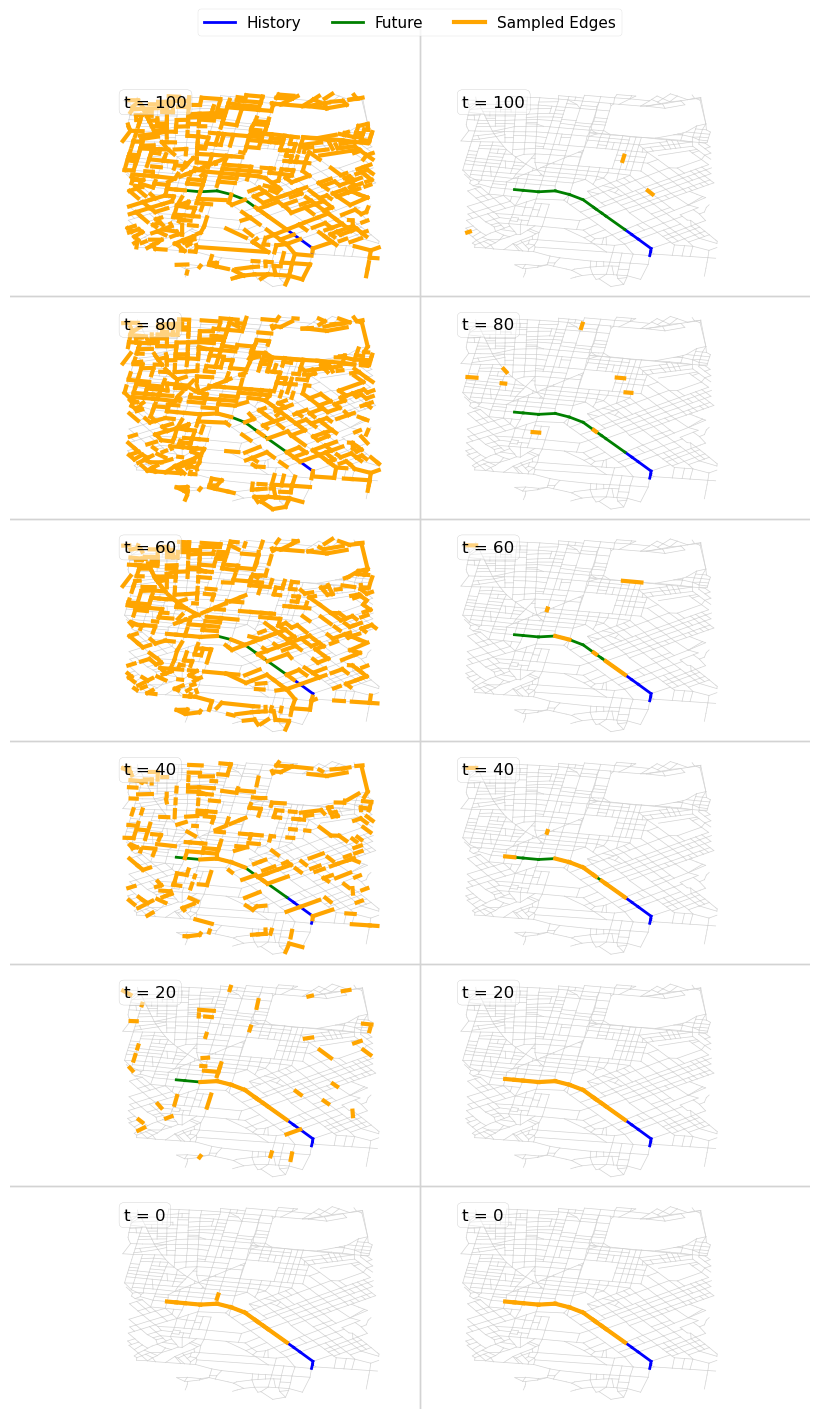

In [16]:
ground_truth_hist = [hist_1, hist_1]
ground_truth_fut = [fut_1, fut_1]
samples = [samples_1_uniform, samples_1_prior]
plot_paths_random(ground_truth_hist, ground_truth_fut, samples, edge_coordinates,
                      num_paths_to_plot=2, zoom_in=False, save_path='partial_denoising_comb.png')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_graphs(edge_coordinates_list, save_path='graphs_grid.png'):
    """
    Plots multiple graphs with specified layout and annotations.

    Parameters:
    - edge_coordinates_list: List of tensors of edge coordinates for each graph.
    - save_path: File path to save the figure.
    """
    # Set the plotting style and parameters
    plt.style.use('seaborn-v0_8-paper')
    plt.rcParams.update({
        'axes.labelsize': 14,
        'axes.titlesize': 18,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'axes.grid': False,
        'grid.alpha': 0.4,
        'lines.linewidth': 1,
    })

    # Titles for each graph
    titles = ["Beijing (T-Drive/Geolife)", "Munich (MoLe)", "Athens (pNEUMA)"]

    # Setup the subplot layout
    fig = plt.figure(figsize=(16, 10))
    import matplotlib.gridspec as gridspec
    gs = gridspec.GridSpec(1, 3)

    # Create subplots
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    ax3 = plt.subplot(gs[2])

    axes = [ax1, ax2, ax3]

    # Plot each graph
    for i, ax in enumerate(axes):
        edge_coordinates = edge_coordinates_list[i]

        # Plot all edges
        for edge in edge_coordinates:
            ax.plot(edge[:, 0], edge[:, 1], color='grey', linewidth=0.5, zorder=1)

        # Remove axes ticks and labels
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')

        # Adjust aspect ratio
        ax.set_aspect('equal')

        # Adjust limits with consistent margins
        xmin, xmax = edge_coordinates[:, :, 0].min(), edge_coordinates[:, :, 0].max()
        ymin, ymax = edge_coordinates[:, :, 1].min(), edge_coordinates[:, :, 1].max()
        x_margin = (xmax - xmin) * 0.05
        y_margin = (ymax - ymin) * 0.05
        ax.set_xlim(xmin - x_margin, xmax + x_margin)
        ax.set_ylim(ymin - y_margin, ymax + y_margin)

    # Adjust layout
    plt.subplots_adjust(wspace=0.05, hspace=0.03)

    # Place titles at the same vertical position
    positions = [ax.get_position() for ax in axes]
    max_y1 = max(pos.y1 for pos in positions)
    title_y = max_y1 + 0.02  # Adjust the offset as needed

    for i, ax in enumerate(axes):
        pos = ax.get_position()
        x = pos.x0 + pos.width / 2
        fig.text(x, title_y, titles[i], ha='center', fontsize=18)

    # Save and show the figure
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


In [ ]:
paths_tdrive, nodes_tdrive, edges_tdrive, tdrive_edge_coordinates = load_new_format(f'/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/data/tdrive_val.h5', features, 'cpu')
paths_munich, nodes_munich, edges_munich, munich_edge_coordinates = load_new_format(f'/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/data/munich_val.h5', features, 'cpu')
paths_pneuma, nodes_pneuma, edges_pneuma, pneuma_edge_coordinates = load_new_format(f'/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/data/pneuma_val.h5', features, 'cpu')
edge_coordinates_list = [tdrive_edge_coordinates, munich_edge_coordinates, pneuma_edge_coordinates]

In [ ]:
plot_graphs(edge_coordinates_list, save_path='graphs_grid.png')

In [ ]:
train_paths, nodes, edges, edge_coordinates = load_new_format(f'/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/data/pneuma_train.h5', features, 'cpu')
val_paths, nodes, edges, edge_coordinates = load_new_format(f'/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/data/pneuma_val.h5', features, 'cpu')
test_paths, nodes, edges, edge_coordinates = load_new_format(f'/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/data/pneuma_test.h5', features, 'cpu')

In [ ]:
print(len(train_paths))

In [ ]:
print(len(nodes))

In [ ]:
print(len(edges))

In [ ]:
sum_train_path_length = sum([len(path['edge_idxs']) for path in train_paths])
sum_val_path_length = sum([len(path['edge_idxs']) for path in val_paths])
sum_test_path_length = sum([len(path['edge_idxs']) for path in test_paths])
avg_path_length = (sum_train_path_length + sum_val_path_length + sum_test_path_length) / (len(train_paths) + len(val_paths) + len(test_paths))
print(f"Average path length: {avg_path_length}")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Import make_axes_locatable
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_graphs_with_heatmap(edge_coordinates_list, trajectories_list, save_path='graphs_grid.png'):
    """
    Plots multiple graphs with heatmaps representing edge usage frequency and returns the percentage of used edges.

    Parameters:
    - edge_coordinates_list: List of tensors of edge coordinates for each graph.
                             Each element is a tensor of shape [num_edges, 2, 2].
    - trajectories_list: List of lists of trajectories for each graph.
                         Each trajectory is a dictionary containing 'edge_idxs' as a list or tensor of edge indices.
    - save_path: File path to save the figure.

    Returns:
    - percentages_used_edges: List of percentages of used edges for each graph.
    """
    # Set the plotting style and parameters
    plt.style.use('seaborn-v0_8-paper')
    plt.rcParams.update({
        'axes.labelsize': 14,
        'axes.titlesize': 18,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'axes.grid': False,
        'grid.alpha': 0.4,
        'lines.linewidth': 1,
    })

    # Titles for each graph
    titles = ["T-Drive", "Geolife", "MoLe", "pNEUMA"]

    num_graphs = len(edge_coordinates_list)

    # Setup the subplot layout
    fig, axes = plt.subplots(2, num_graphs // 2, figsize=(16, 10))
    axes = axes.flatten()

    percentages_used_edges = []  # To store the percentages of used edges

    # Adjust layout to reduce space between subplots
    plt.subplots_adjust(wspace=0.05, hspace=0.1, right=0.85)  # Reduced spaces and adjusted right for colorbar

    # For each graph
    for i, ax in enumerate(axes):
        edge_coordinates = edge_coordinates_list[i]
        trajectories = trajectories_list[i]  # List of trajectories for the current graph

        num_edges = edge_coordinates.shape[0]

        # Flatten the list of trajectories to get all used edge indices
        all_used_edges = []
        for traj in trajectories:
            # Convert trajectory to numpy array if it's a tensor
            if isinstance(traj['edge_idxs'], torch.Tensor):
                traj_indices = traj['edge_idxs'].numpy()
            elif isinstance(traj['edge_idxs'], list):
                traj_indices = np.array(traj['edge_idxs'])
            all_used_edges.append(traj_indices)
        all_used_edges = np.concatenate(all_used_edges)

        # Count the usage frequency of each edge
        edge_usage_counts = np.zeros(num_edges, dtype=int)
        unique, counts = np.unique(all_used_edges, return_counts=True)
        edge_usage_counts[unique] = counts

        # Calculate the percentage of used edges
        num_used_edges = np.count_nonzero(edge_usage_counts)
        percentage_used = (num_used_edges / num_edges) * 100
        percentages_used_edges.append(percentage_used)

        # Normalize edge usage counts for coloring
        max_count = edge_usage_counts.max()
        if max_count == 0:
            max_count = 1  # To avoid division by zero
        edge_usage_norm = edge_usage_counts / max_count  # Normalize between 0 and 1

        # Create a colormap
        cmap = plt.cm.coolwarm  # You can choose any colormap you like
        norm = plt.Normalize(vmin=0, vmax=1)

        # Define linewidths based on usage counts
        lw_min = 1.0
        lw_max = 4.0
        edge_lw = lw_min + (edge_usage_norm * (lw_max - lw_min))

        # Plot all edges
        for idx, edge in enumerate(edge_coordinates):
            if edge_usage_counts[idx] == 0:
                # Edge never used
                color = 'lightgrey'
                lw = 0.5
            else:
                # Edge used
                color = cmap(norm(edge_usage_norm[idx]))
                lw = edge_lw[idx]
            ax.plot(edge[:, 0], edge[:, 1], color=color, linewidth=lw, zorder=1)

        # Remove axes ticks and labels
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')

        # Adjust aspect ratio
        ax.set_aspect('equal')

        # Adjust limits with consistent margins
        xmin, xmax = edge_coordinates[:, :, 0].min(), edge_coordinates[:, :, 0].max()
        ymin, ymax = edge_coordinates[:, :, 1].min(), edge_coordinates[:, :, 1].max()
        x_margin = (xmax - xmin) * 0.05
        y_margin = (ymax - ymin) * 0.05
        ax.set_xlim(xmin - x_margin, xmax + x_margin)
        ax.set_ylim(ymin - y_margin, ymax + y_margin)

        # Set title above each subplot with appropriate padding
        ax.set_title(titles[i], fontsize=18, pad=5)

    # Add a single colorbar for all subplots
    cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # Adjust position as needed
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=14)
    cbar.ax.set_ylabel('Usage Frequency', fontsize=16, rotation=270, labelpad=15)

    # Save and show the figure
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    return percentages_used_edges


In [9]:
paths_tdrive_0, nodes_tdrive, edges_tdrive, tdrive_edge_coordinates = load_new_format(f'/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/data/tdrive_train.h5', features, 'cpu')
paths_tdrive_1, nodes_tdrive, edges_tdrive, tdrive_edge_coordinates = load_new_format(f'/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/data/tdrive_val.h5', features, 'cpu')
paths_tdrive_2, nodes_tdrive, edges_tdrive, tdrive_edge_coordinates = load_new_format(f'/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/data/tdrive_test.h5', features, 'cpu')
paths_geolife_0, nodes_geolife, edges_geolife, geolife_edge_coordinates = load_new_format(f'/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/data/geolife_train.h5', features, 'cpu')
paths_geolife_1, nodes_geolife, edges_geolife, geolife_edge_coordinates = load_new_format(f'/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/data/geolife_val.h5', features, 'cpu')
paths_geolife_2, nodes_geolife, edges_geolife, geolife_edge_coordinates = load_new_format(f'/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/data/geolife_test.h5', features, 'cpu')
paths_munich_0, nodes_munich, edges_munich, munich_edge_coordinates = load_new_format(f'/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/data/munich_train.h5', features, 'cpu')
paths_munich_1, nodes_munich, edges_munich, munich_edge_coordinates = load_new_format(f'/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/data/munich_val.h5', features, 'cpu')
paths_munich_2, nodes_munich, edges_munich, munich_edge_coordinates = load_new_format(f'/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/data/munich_test.h5', features, 'cpu')
paths_pneuma_0, nodes_pneuma, edges_pneuma, pneuma_edge_coordinates = load_new_format(f'/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/data/pneuma_train.h5', features, 'cpu')
paths_pneuma_1, nodes_pneuma, edges_pneuma, pneuma_edge_coordinates = load_new_format(f'/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/data/pneuma_val.h5', features, 'cpu')
paths_pneuma_2, nodes_pneuma, edges_pneuma, pneuma_edge_coordinates = load_new_format(f'/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/data/pneuma_test.h5', features, 'cpu')


/tmp/ipykernel_1727737/2379480112.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nodes = [(i, {'pos': torch.tensor(pos, device=device)}) for i, pos in enumerate(node_coordinates)]
100%|██████████| 7583/7583 [00:03<00:00, 2435.71it/s]


In [10]:
tdrive_all = paths_tdrive_0 + paths_tdrive_1 + paths_tdrive_2
geolife_all = paths_geolife_0 + paths_geolife_1 + paths_geolife_2
munich_all = paths_munich_0 + paths_munich_1 + paths_munich_2
pneuma_all = paths_pneuma_0 + paths_pneuma_1 + paths_pneuma_2
trajectories_list = [tdrive_all, geolife_all, munich_all, pneuma_all]
coordinates_list = [tdrive_edge_coordinates, geolife_edge_coordinates, munich_edge_coordinates, pneuma_edge_coordinates]

In [ ]:
precentages = plot_graphs_with_heatmap(coordinates_list, trajectories_list, save_path='heatmap.png')
print(precentages)

In [ ]:
trajectories_list_train = [paths_tdrive_0, paths_geolife_0, paths_munich_0, paths_pneuma_0]
trajectories_list_val = [paths_tdrive_1, paths_geolife_1, paths_munich_1, paths_pneuma_1]
trajectories_list_test = [paths_tdrive_2, paths_geolife_2, paths_munich_2, paths_pneuma_2]

In [ ]:
precentages_val = plot_graphs_with_heatmap(coordinates_list, trajectories_list_val, save_path='val_heatmap.png')

In [ ]:
precentages_test = plot_graphs_with_heatmap(coordinates_list, trajectories_list_test, save_path='test_heatmap.png')

In [6]:
def load_dataset(name):
    paths = []
    for split in ['train', 'val', 'test']:
        file_path = f'/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/data/{name}_{split}.h5'
        dataset_paths, _, _, _ = load_new_format(file_path, [], 'cpu')
        paths.extend(dataset_paths)
    return paths

# List of datasets and their display names
datasets = ['tdrive', 'geolife', 'munich', 'pneuma']
dataset_names = ['T-Drive', 'Geolife', 'Munich', 'pNEUMA']
all_paths = {}

# Load datasets
for dataset in datasets:
    print(f"Loading {dataset} dataset...")
    paths = load_dataset(dataset)
    all_paths[dataset] = paths

# Compute path lengths (number of edge indices in each path)
path_lengths = {}
for dataset in datasets:
    lengths = [len(path['edge_idxs']) for path in all_paths[dataset]]
    path_lengths[dataset] = lengths


Loading tdrive dataset...


/tmp/ipykernel_1109610/2379480112.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nodes = [(i, {'pos': torch.tensor(pos, device=device)}) for i, pos in enumerate(node_coordinates)]
100%|██████████| 697/697 [00:00<00:00, 924.30it/s]


Loading geolife dataset...


100%|██████████| 2665/2665 [00:02<00:00, 936.69it/s]


Loading munich dataset...


100%|██████████| 266/266 [00:00<00:00, 1028.72it/s]


Loading pneuma dataset...


100%|██████████| 7583/7583 [00:03<00:00, 1977.05it/s]


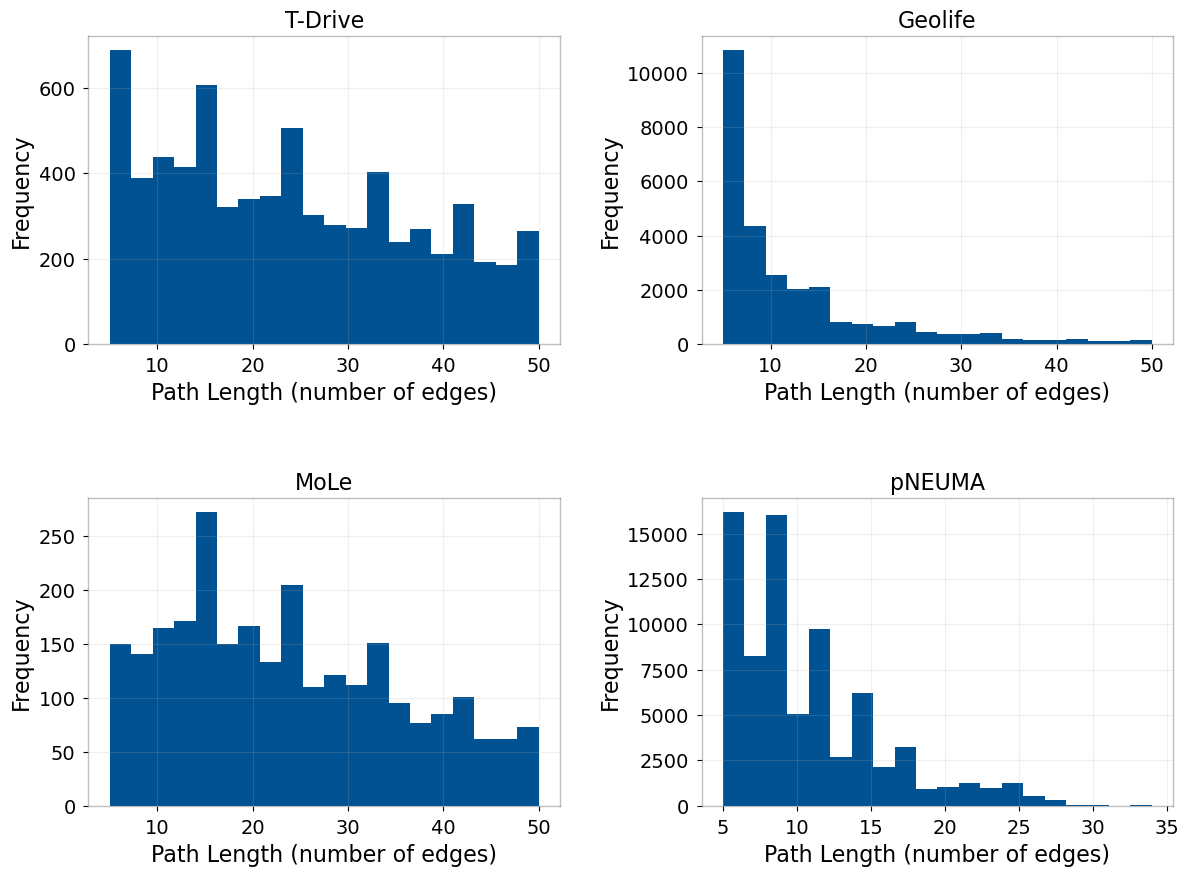

In [14]:
#import matplotlib.pyplot as plt

# Set the plotting style and parameters
plt.style.use('seaborn-v0_8-paper')
plt.rcParams.update({
    'axes.labelsize': 16,
    'axes.titlesize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 16,
    'axes.grid': True,
    'grid.alpha': 0.2,
    'lines.linewidth': 1,
})

# Create a 2x2 subplot grid with increased spacing
fig, axes = plt.subplots(2, 2, figsize=(14, 10), gridspec_kw={'wspace': 0.3, 'hspace': 0.5})
axes = axes.flatten()

# Define colors for the histograms
hist_colors = ['#005293', '#99c6eb', '#A2AD00', '#E37222']
dataset_names = ['T-Drive', 'Geolife', 'MoLe', 'pNEUMA']

# Assume 'datasets' and 'path_lengths' are defined
for idx, dataset in enumerate(datasets):
    ax = axes[idx]
    lengths = path_lengths[dataset]
    ax.hist(lengths, bins=20, color=hist_colors[0])
    ax.set_title(f"{dataset_names[idx]}")
    ax.set_xlabel('Path Length (number of edges)')
    ax.set_ylabel('Frequency')

    # Adjust spines
    spine_color = 'grey'
    spine_alpha = 0.5
    for spine in ax.spines.values():
        spine.set_color(spine_color)
        spine.set_alpha(spine_alpha)
        spine.set_linewidth(1)

# Hide any unused subplots (in case of fewer datasets)
for idx in range(len(datasets), 4):
    fig.delaxes(axes[idx])

# Optionally adjust layout padding
# plt.tight_layout(pad=2.0, w_pad=2.0, h_pad=2.0)

# Save and show the plot
plt.savefig('path_lengths_histograms.png', dpi=300, bbox_inches='tight')
plt.show()
